<a id="contents"></a><br>
# Contents
1. [setup](#setup)
2. [Check out read depths](#readDepth)
3. [denoising and initial phyloseq object](#dada2)
4. [Adjustment of abundances](#transformation)
5. [Diversity overview](#diversityOverview)


<a id="setup"></a>
## R working environment

In [1]:
library(dada2)
library(phyloseq)
library(Biostrings)
library(ape)
library(ggplot2)
library(RColorBrewer)

Loading required package: Rcpp

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: ‘IRanges’


The following object is ma

<a id="dada2"></a>
## Denoising and initial phyloseq object 

Prior to this, we trimmed our phased primers with `cutadapt`. Here we generate ASVs using DADA2, create a phylogeny of our 16s reads, and combine it with the our sample data into a phyloseq object as the basis for most downstream analyses. 

In [2]:
trimReadDir <- "/home/daniel/Documents/projects/wernerSphagnum/sampleData/sequencingSamples/trimmed_reads"
setwd(trimReadDir)

In [3]:
fileNames <- list.files(pattern="fastq.gz")
filterPath <- "/home/daniel/Documents/projects/wernerSphagnum/sampleData/sequencingSamples/filteredReads"
out <- filterAndTrim(fileNames, filterPath,
              maxN=0, maxEE=2, truncQ=2, rm.phix=TRUE,
              compress=TRUE, multithread=TRUE)

In [8]:
sum(out[,2]) / sum(out[,1]) ## ~60% reads retained

[1] 0.6062987

In [10]:
setwd(filterPath)
err <- learnErrors(fileNames, multithread=TRUE)

105955917 total bases in 386150 reads from 9 samples will be used for learning the error rates.


In [4]:
#dadaF <- dada(fileNames, err=err, pool=TRUE, multithread=TRUE)
#save(dadaF, file="/home/daniel/Documents/projects/wernerSphagnum/sequenceAnalysis/dadaPeat.rda")
load("/home/daniel/Documents/projects/wernerSphagnum/sequenceAnalysis/dadaPeat.rda")

In [5]:
seqtab <- makeSequenceTable(dadaF)
seqtab.nochim <- removeBimeraDenovo(seqtab, method="consensus", multithread=TRUE, verbose=TRUE)

Identified 2183 bimeras out of 7976 input sequences.



In [8]:
homedir="/home/daniel/Documents/projects/wernerSphagnum/sequenceAnalysis/"
envData <- read.csv(paste0(homedir,"envDataPeat.csv"))
rownames(seqtab.nochim) <- gsub("trimmed_reads.*_S", "S", rownames(seqtab.nochim)) |>
gsub("_L.*fastq.gz","",x=_)

In [10]:
rownames(seqtab.nochim)

[1] "S1"  "S2"  "S3"  "S4"  "S5"  "S6"  "S7"  "S8"  "S9"  "S10" "S11" "S12"
[13] "S13" "S14" "S15" "S16" "S17" "S18" "S19" "S20" "S21" "S22" "S23" "S24"
[25] "S25" "S26" "S27" "S28" "S29" "S30" "S31" "S32" "S33" "S34" "S35" "S36"
[37] "S37" "S38" "S39" "S40" "S41" "S42" "S43" "S44" "S47"

In [11]:
path2silvaDB <- "/media/vol/phylo_dbs/silva/silva138.2/silva_nr99_v138.2_toGenus_trainset.fa"
taxa <- assignTaxonomy(seqtab.nochim, path2silvaDB, multithread=TRUE)

Warning message in assignTaxonomy(seqtab.nochim, path2silvaDB, multithread = TRUE):
“Some sequences were shorter than 50 nts and will not receive a taxonomic classification.”


In [26]:
ps <- phyloseq(otu_table(seqtab.nochim, taxa_are_rows=FALSE), tax_table(taxa))

In [27]:
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
## give our ASVs pretty names instead of DNA sequences:
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))

In [31]:
envData <- read.csv(paste0(homedir,"envDataPeat.csv"), row.names="SampleName")
envData$DepthSection <- as.numeric(envData$DepthSection)
sample_data(ps) = envData

Warning message:
“NAs introduced by coercion”


We still need a 16s tree. We'll use `SSU-ALIGN`, in the BASH terminal. First, we'll need our rep sequences, from our phyloseq object:

In [48]:
rs <- refseq(ps)
writeXStringSet(rs,"wernerSphagnumRefSeqs.fa", format="fasta")

In [50]:
setwd("/home/daniel/Documents/projects/wernerSphagnum/sequenceAnalysis")
#save(ps, file="peat16sPS.rda")

Run the alignment, in BASH terminal.

In [ ]:
#### change kernel to BASH !!! 
nohup ssu-align -n bacteria wernerSphagnumRefSeqs.fa wernerSphagnumRefSeqs_ali &
## then a strict mask, don't trust any ambiguous calls, because we are forcing the bacterial model on archea
ssu-mask --pf 0.9999 --pt 0.9999 wernerSphagnumRefSeqs_ali
## to get a fasta output of the alignment (what we probably need)
ssu-mask --stk2afa wernerSphagnumRefSeqs_ali
ssuAlignOut="/media/vol1/daniel/wernerPeat/wernerSphagnumRefSeqs_ali/wernerSphagnumRefSeqs_ali.bacteria.afa"

Use `FastTree2` to make the tree:

In [ ]:
FastTree -gtr -nt < $ssuAlignOut > wernerPeatFastTree.nwk

Back in R - use integrate this tree into our PS object:

In [55]:
## get Archea for rooting tree:
archFilter <- as.vector(tax_table(ps)[,"Kingdom"] == "Archaea")
archFilter[is.na(archFilter)] <- FALSE
archaeaPS = prune_taxa(archFilter, ps)

Some archaeal groups didn't align anywhere:

In [58]:
notInTree = taxa_names(archaeaPS)[!(taxa_names(archaeaPS) %in% aa$tip.label)]; notInTree

[1] "ASV4652" "ASV4698" "ASV4701" "ASV5339"

In [59]:
tax_table(ps)[notInTree]

,Kingdom,Phylum,Class,Order,Family,Genus
ASV4652,Archaea,Halobacteriota,Halobacteria,Halobacterales,Haloferacaceae,Haloplanus
ASV4698,Archaea,Nanoarchaeota,Nanoarchaeia,Pacearchaeales,NA,NA
ASV4701,Archaea,Halobacteriota,Halobacteria,Halobacterales,Haloferacaceae,Halovenus
ASV5339,Archaea,Nanoarchaeota,Nanoarchaeia,Pacearchaeales,NA,NA


In [61]:
notInTreeAbund <- otu_table(ps)[,notInTree]
notInTreeAbund[rowSums(notInTreeAbund) > 0,]

,ASV4652,ASV4698,ASV4701,ASV5339
S29,0,24,0,1
S30,0,19,0,7
S34,0,3,0,0
S47,51,0,46,0


These unaligned archeal groups are relatively low abundance. For the moment, we will leave them out. We can reincorporate them if they are of interest. 

In [64]:
inTree = !(rownames(tax_table(ps)) %in% notInTree)
ps.inTree <- prune_taxa(inTree, ps)

Root our tree with the Archeae and add this to our phyloseq object. 

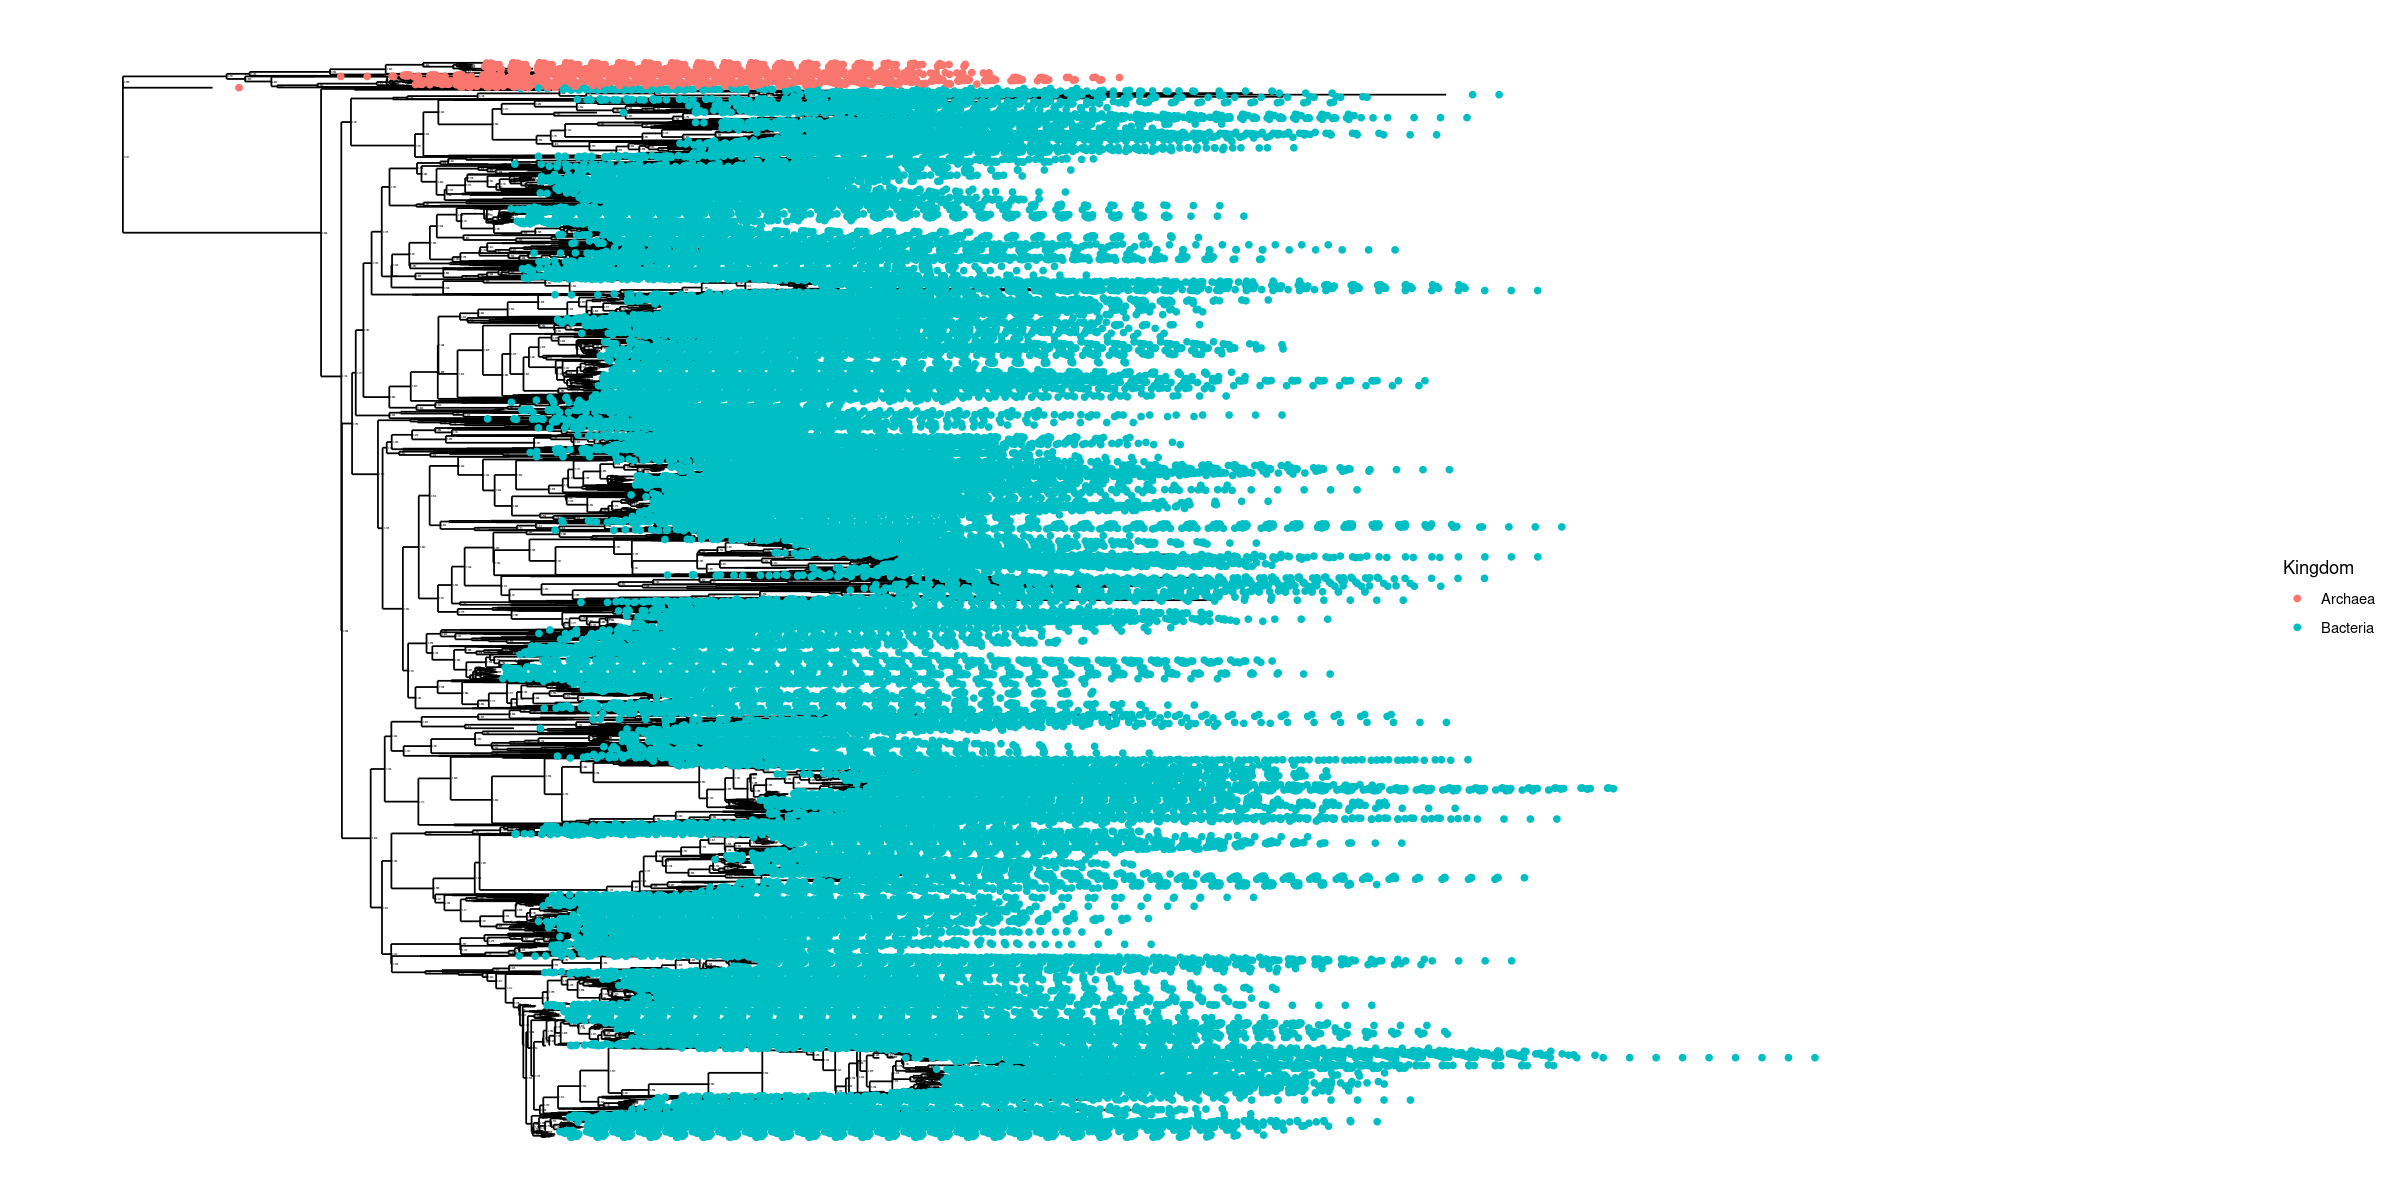

In [66]:
rooted_tree = root(aa, outgroup = taxa_names(archaeaPS), resolve.root = TRUE)
phy_tree(ps.inTree) <- rooted_tree
plot_tree(ps.inTree, color="Kingdom")

From here, we'll use just these groups that aligned well in our 16S tree. I'm afraid the ones that didn't are low quality reads or some other noise. 

Check read abundances:

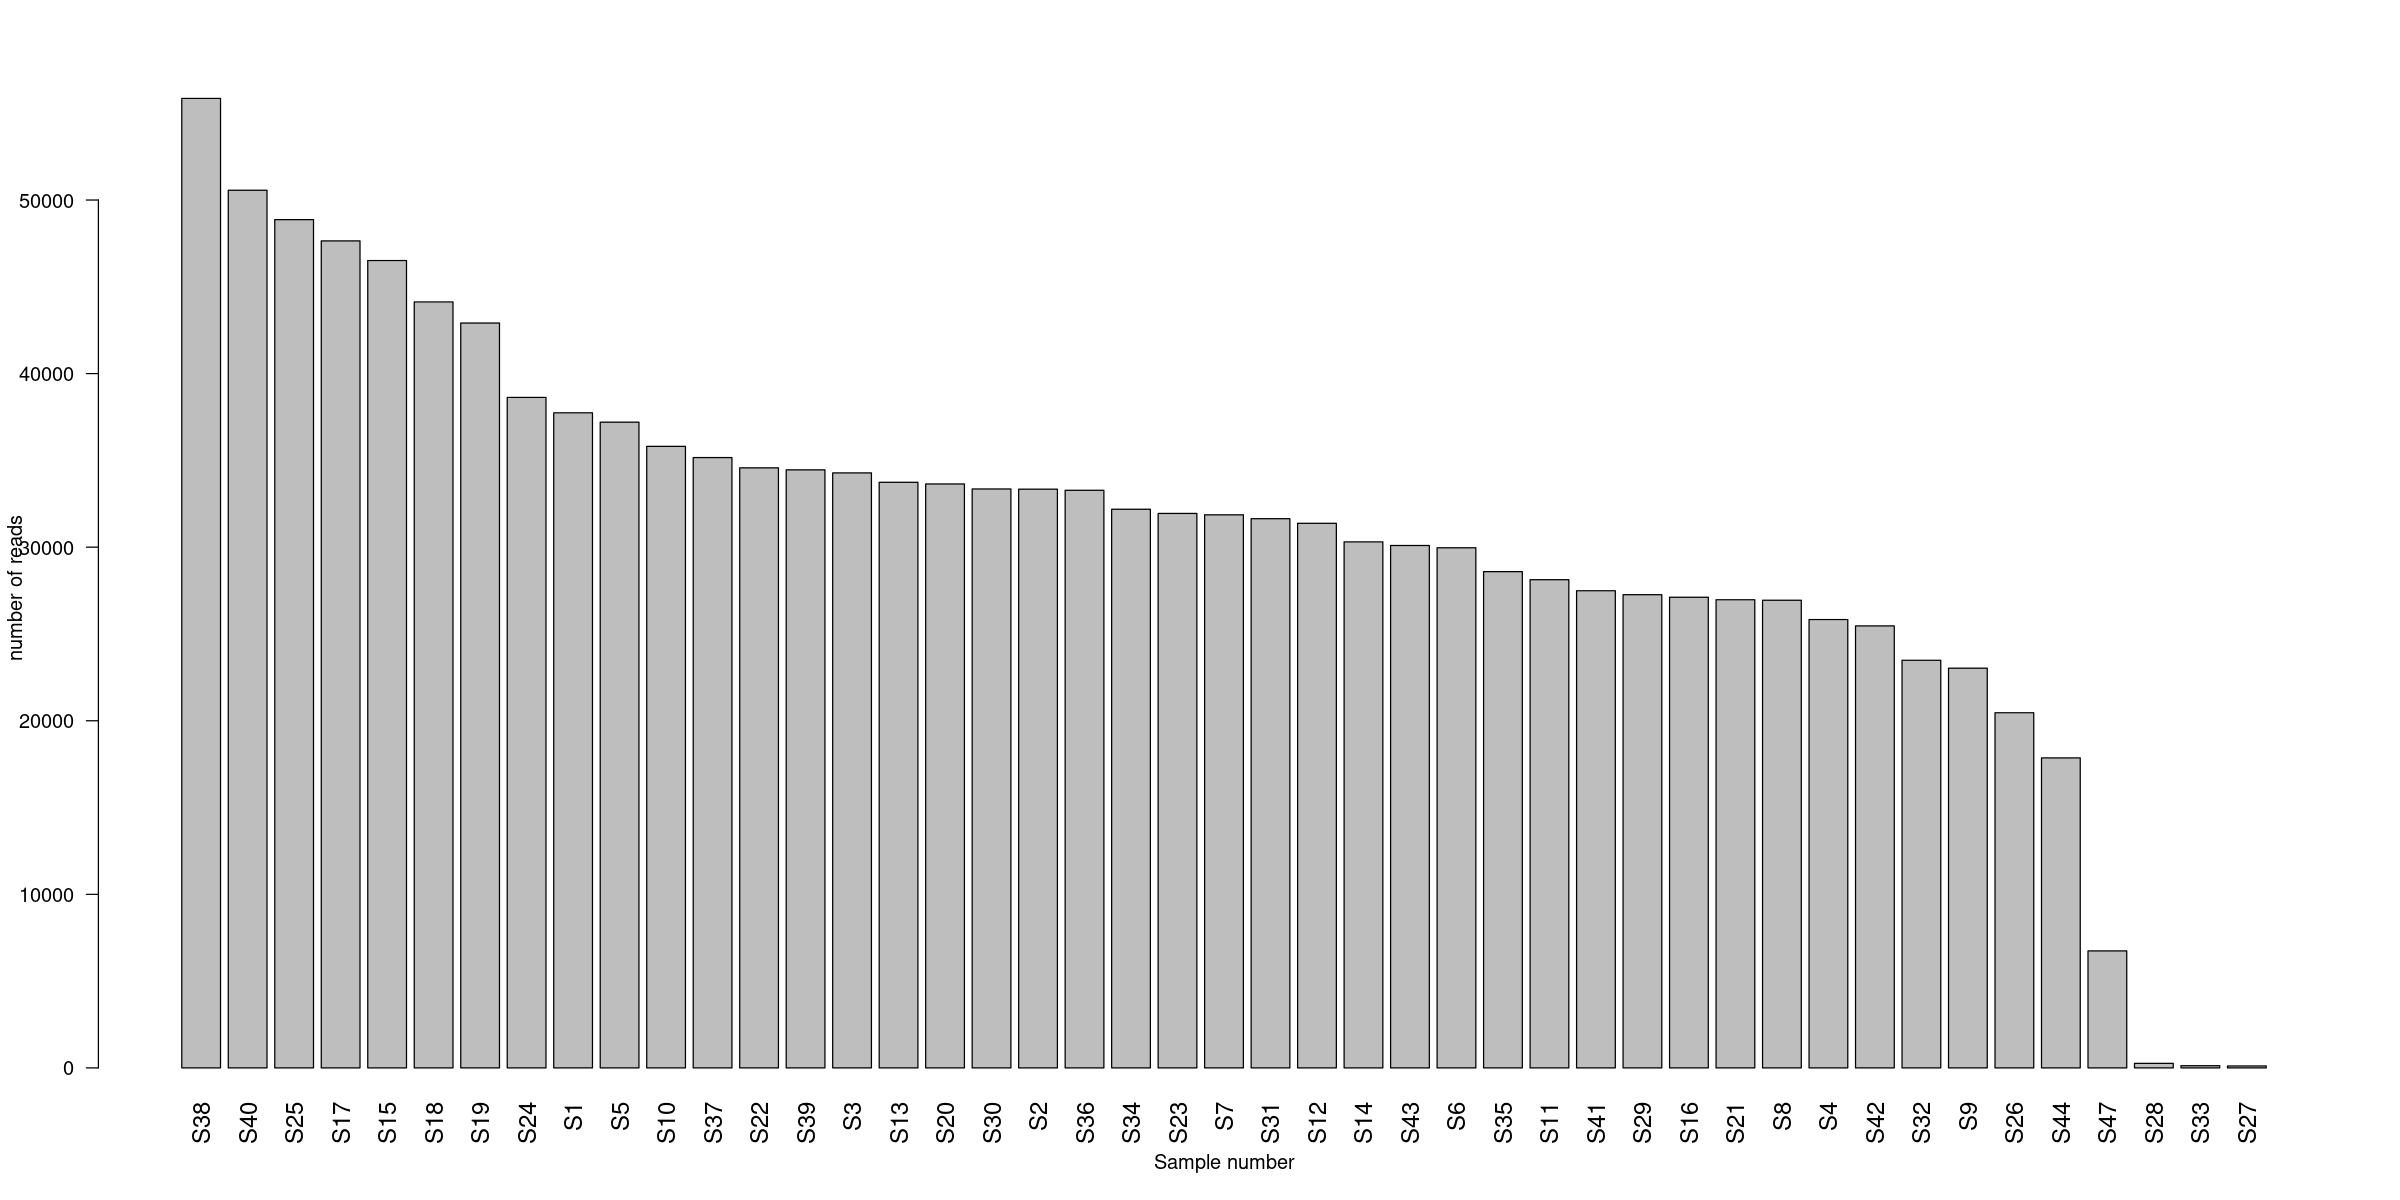

In [67]:
options(repr.plot.width = 20, repr.plot.height = 10)

barplot(sort(sample_sums(ps), decreasing=TRUE), 
        ylab="number of reads",
        xlab="Sample number",
        cex.names=1.2, 
        las=2)

Looks like three samples essentially failed: S27, S28, and S33. These are:

In [35]:
sample_data(ps)[c("S27","S28","S33")]

,SampleID,Subsite,DepthSection,EcoCont,Core
,<chr>,<chr>,<dbl>,<chr>,<chr>
S27,AT2_43-63,Thermokarst,1,Ecological,AT2
S28,AT2_63-83,Thermokarst,2,Ecological,AT2
S33,AT3_80-100,Thermokarst,2,Ecological,AT3


In [119]:
sample_sums(ps)[c("S27","S28","S33")]

S27 S28 S33 
111 262 127

To view abundances of any given sample, we have a custom function:

In [72]:
load("ps_inTree.rda")

In [68]:
rankAb <- function(phyObj, sampleName, ylimit=500, ntax=NULL, textatX=100, textatY=(ylimit-40)){
    sampleNo0filter <- get_taxa(phyObj, sampleName) > 0
    if(is.null(ntax)) ntax=sum(sampleNo0filter)
    print(sum(sampleNo0filter)) ## let user know how many unique taxa are in sample
    sampleNo0 <- get_taxa(phyObj, sampleName)[sampleNo0filter]
    sampleNo0 <- sort(sampleNo0, decreasing=TRUE)
    sampleNo0 <- sampleNo0[1:ntax]
    taxaNames=tax_table(phyObj)[ names(sampleNo0), "Genus"]
    nuASV <- paste("number of unique ASVs = ",sum(sampleNo0filter), sep="")
    par(cex.axis = .75, mar=c(25,4,4,2))
    barplot(sampleNo0,
        ylim = c(0,ylimit),
        main=sampleName,
        cex.names=1.5,
        las=2,
        names.arg=taxaNames,
           )
    text(textatX, textatY,  nuASV, cex = 2, )
}

Use this to check the abundances of our mock community (S42, S43):

[1] 392


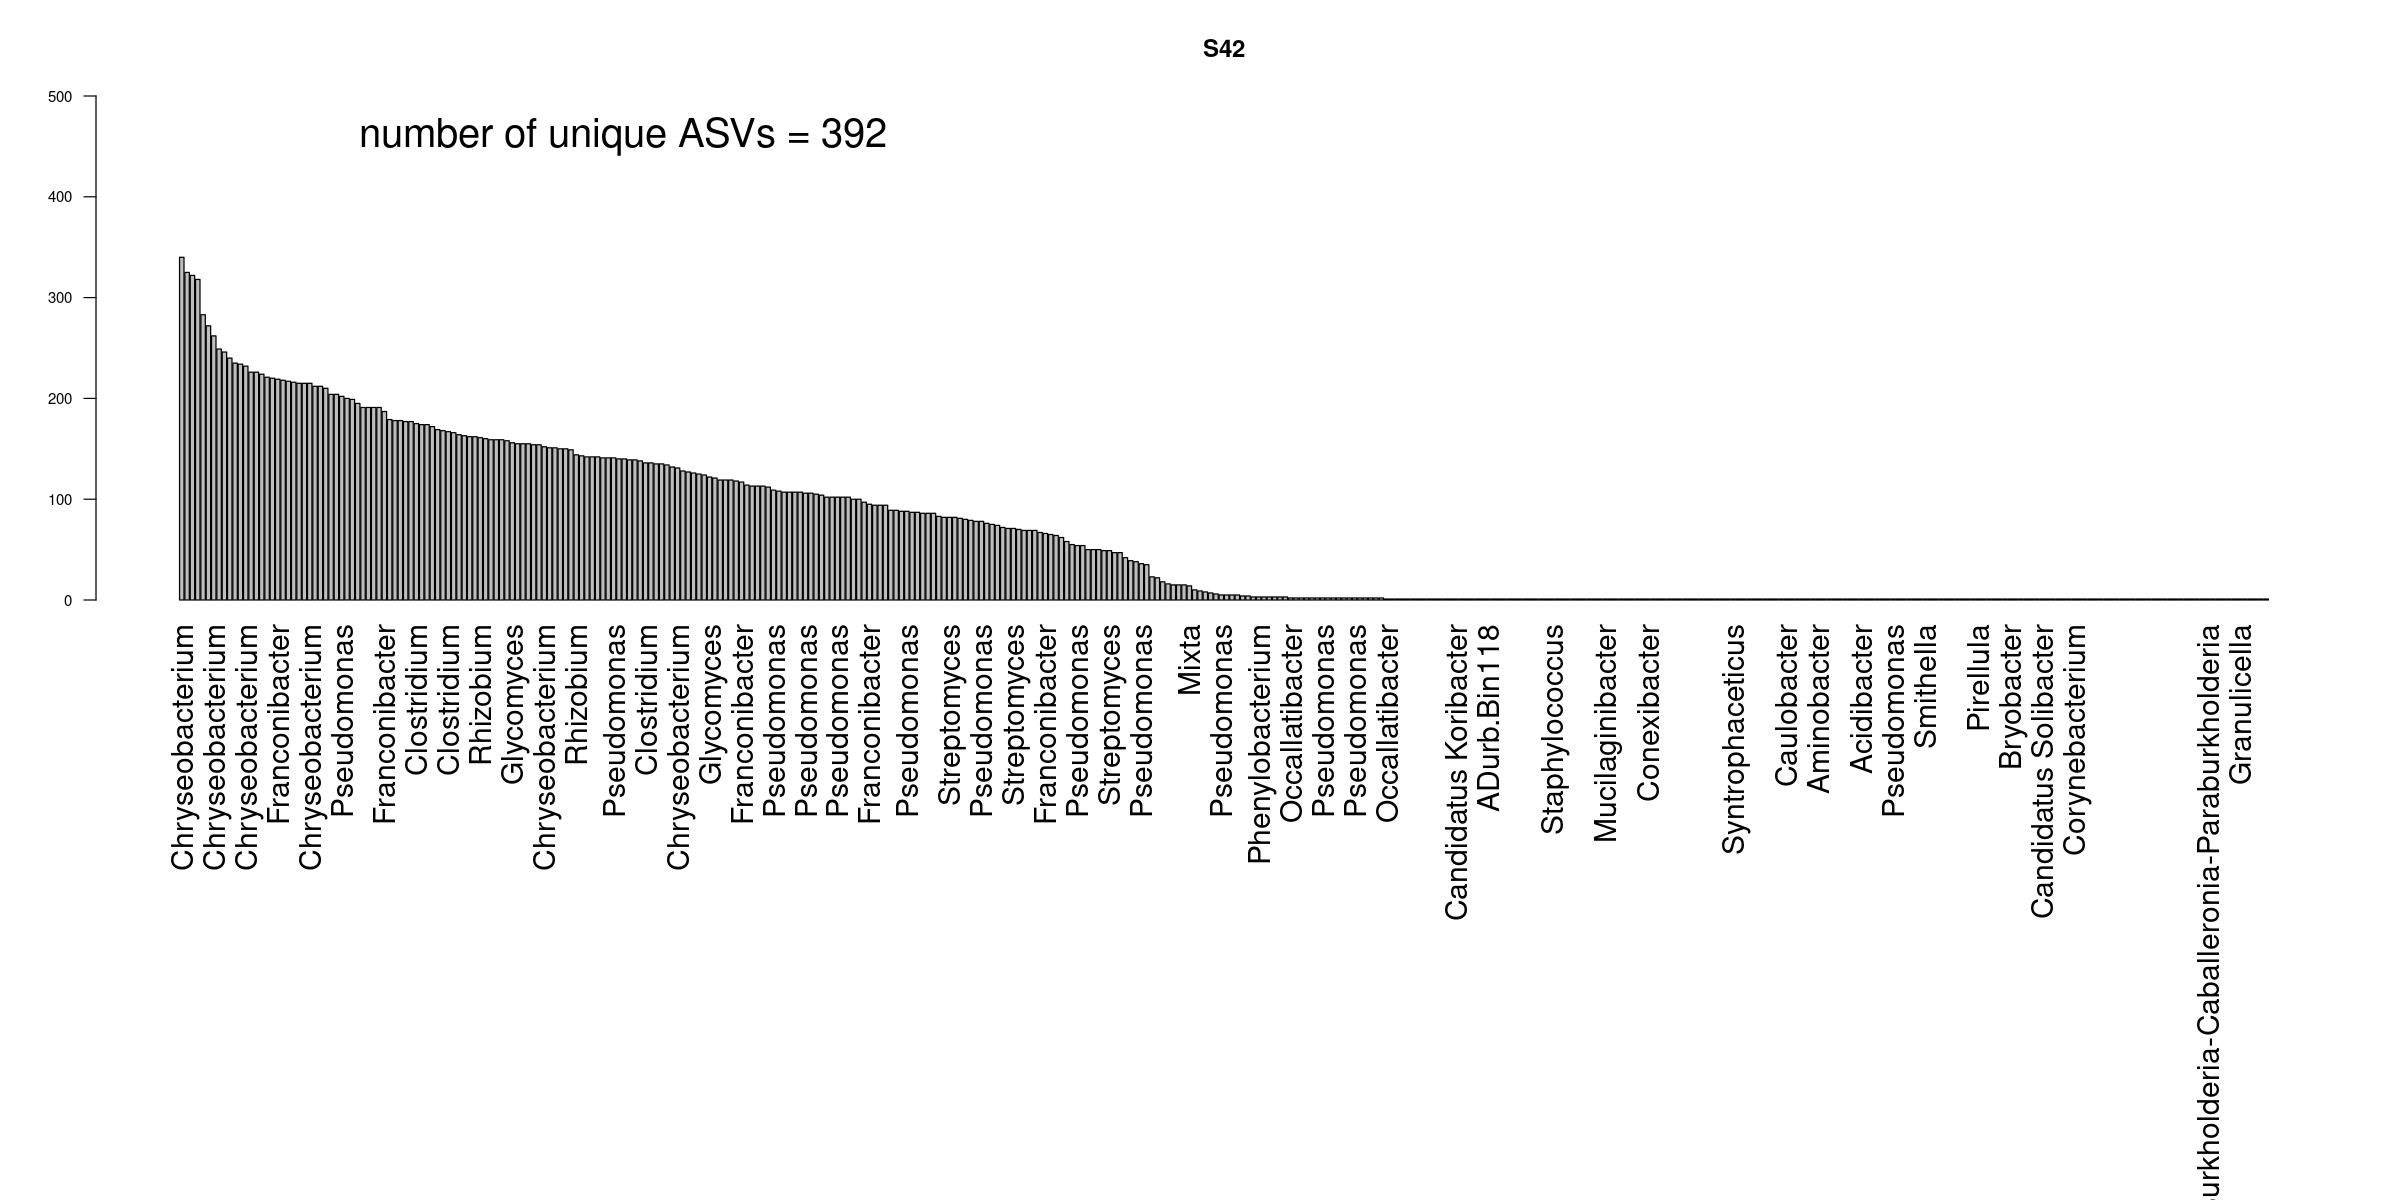

In [76]:
rankAb(ps.inTree,"S42")

[1] 392


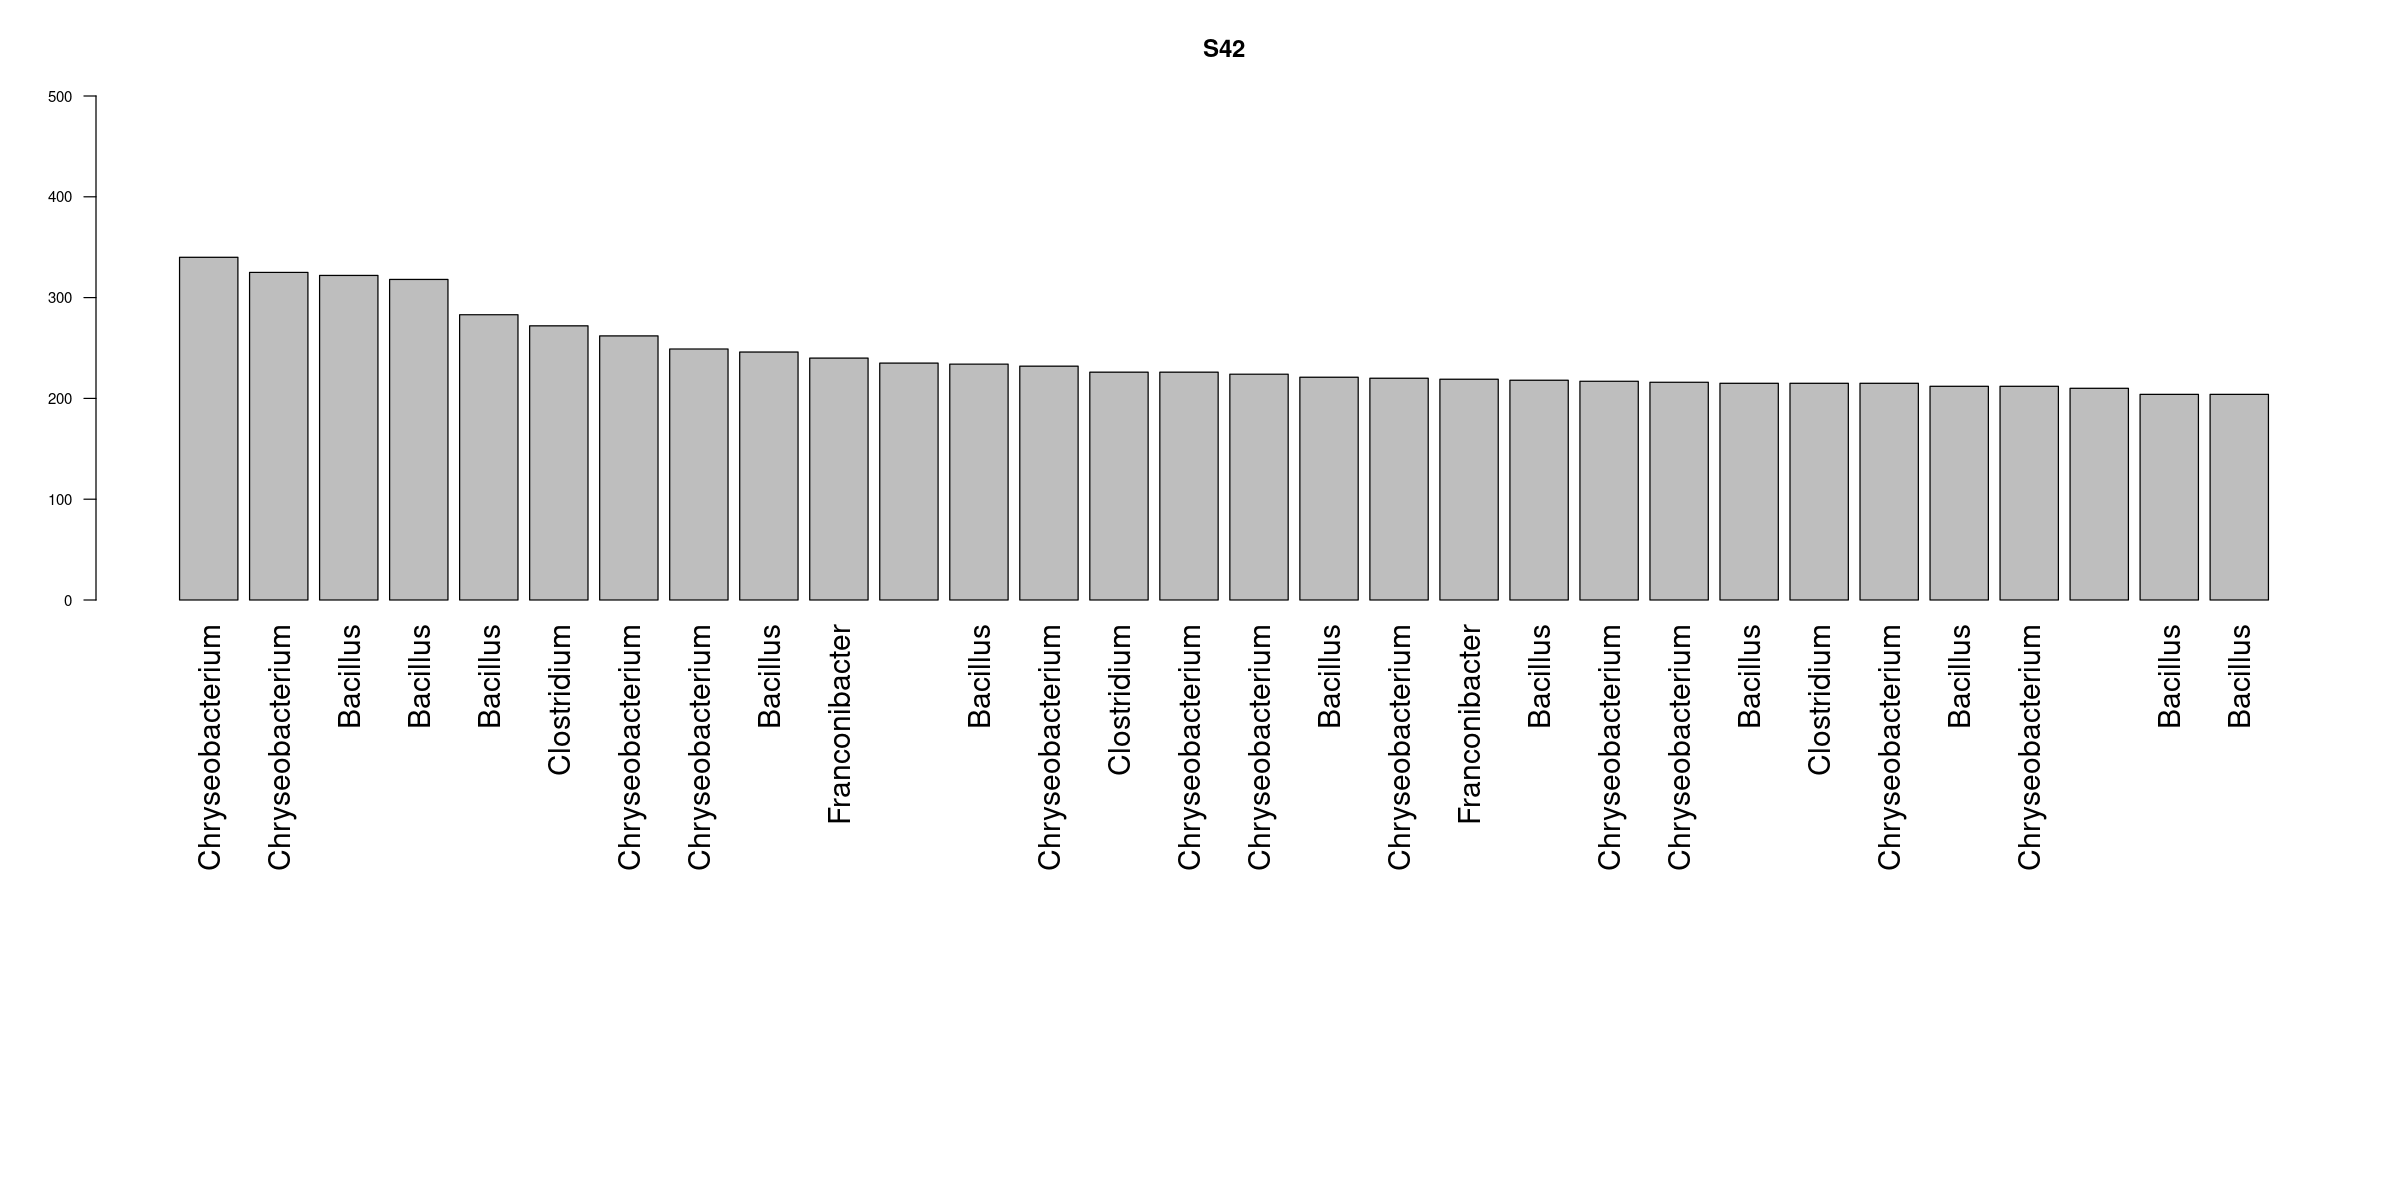

In [77]:
rankAb(ps.inTree,"S42", ntax=30)

[1] 385


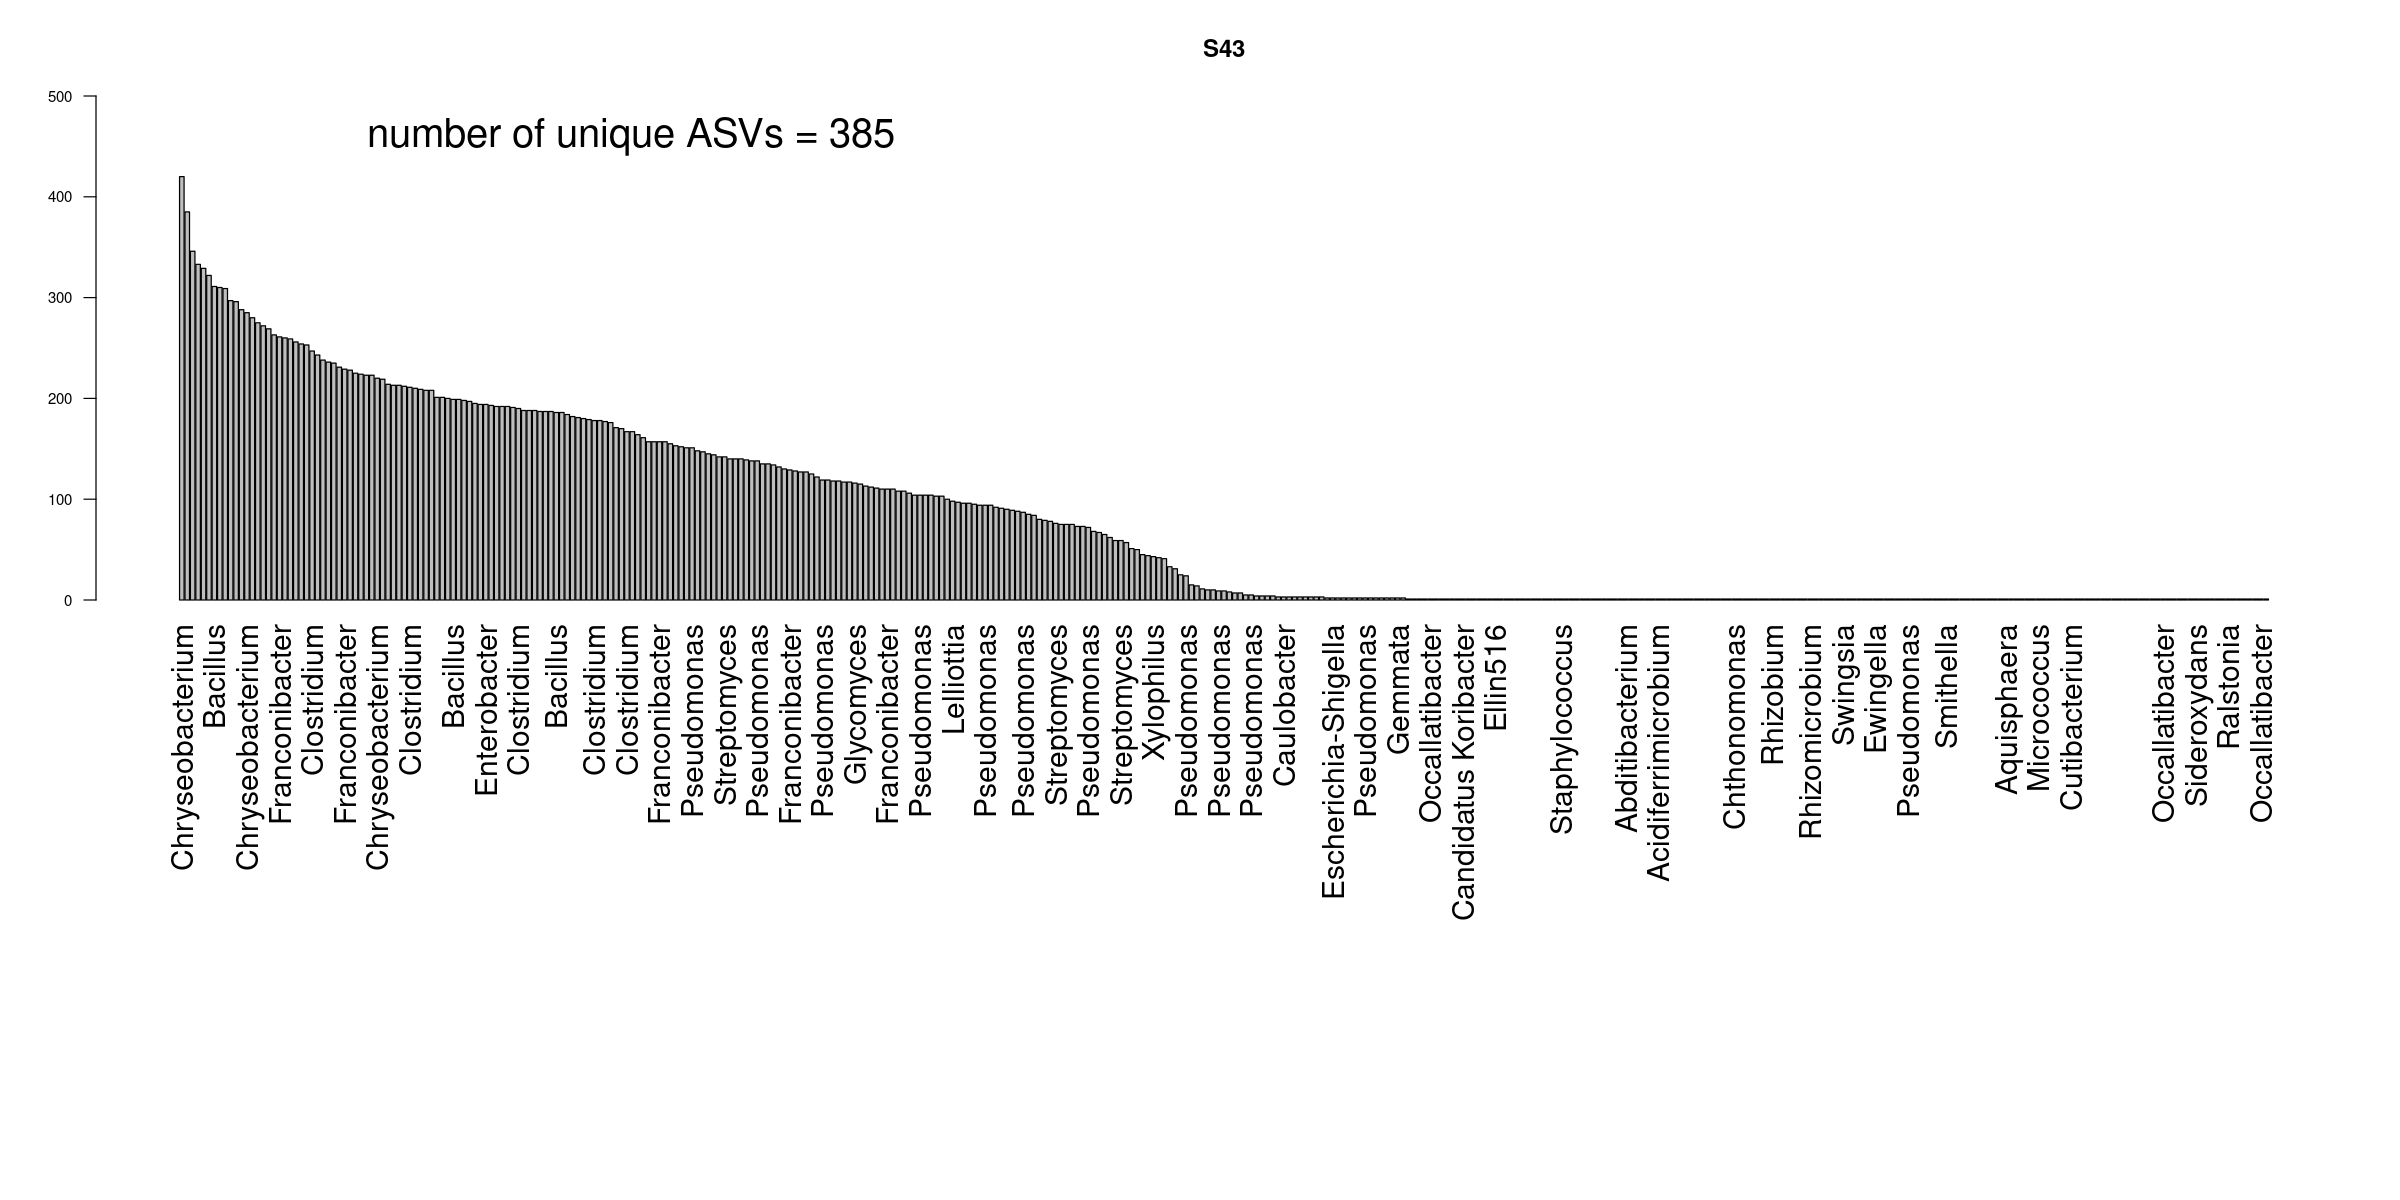

In [78]:
rankAb(ps.inTree,"S43")

[1] 385


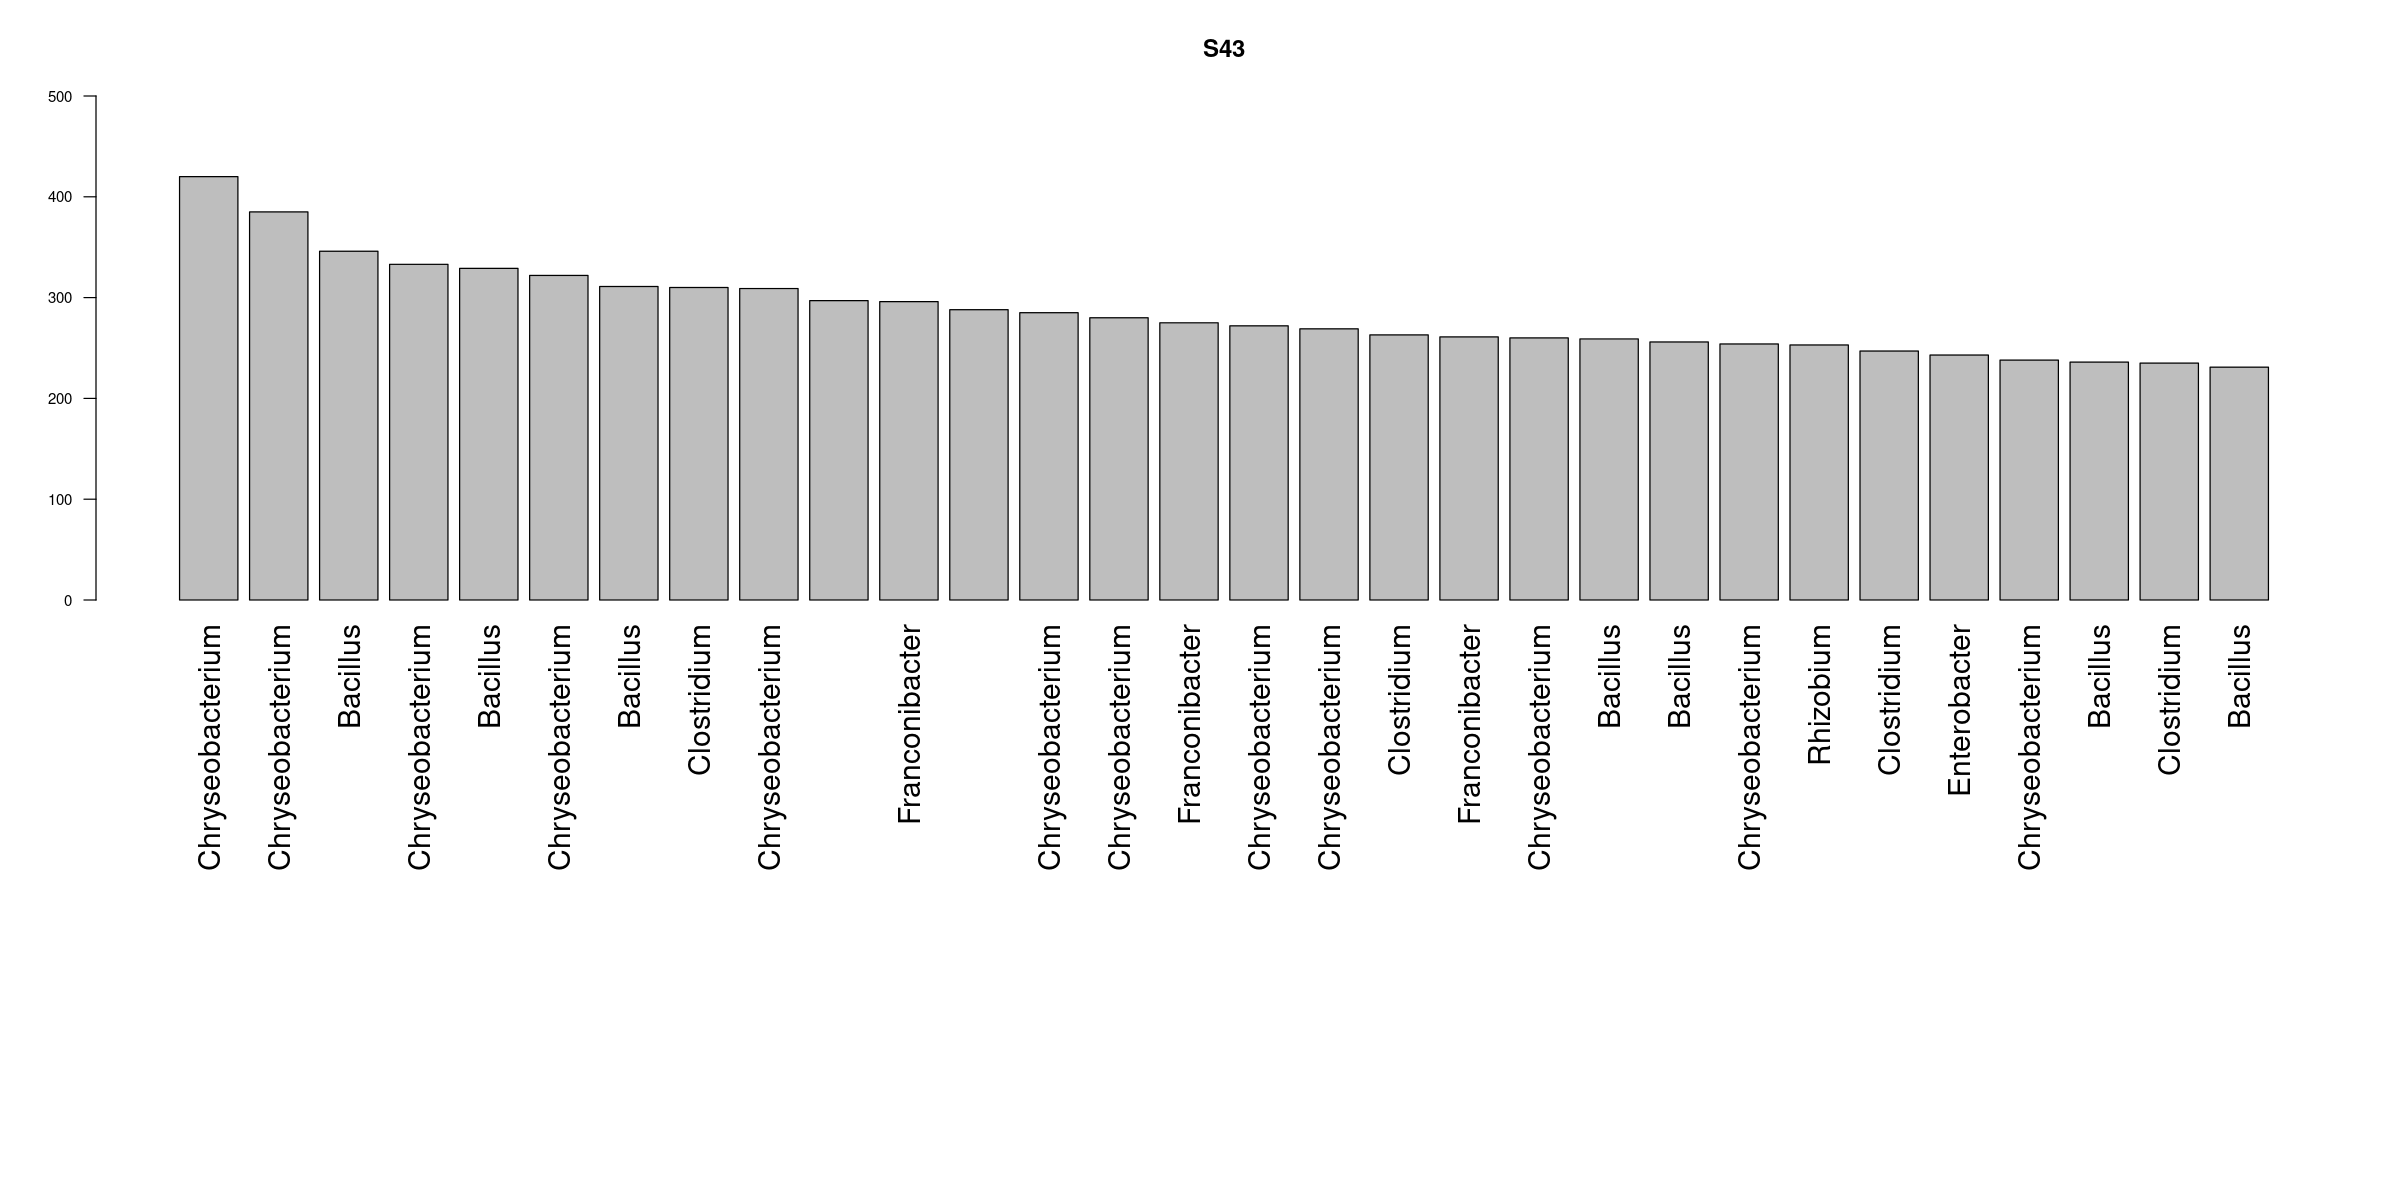

In [75]:
rankAb(ps.inTree,"S43",ntax=30)

We see a lot of splitting of OTUs. If we glom by genus:

In [79]:
ps.inTree.genus <- tax_glom(ps.inTree, taxrank="Genus")

[1] 56


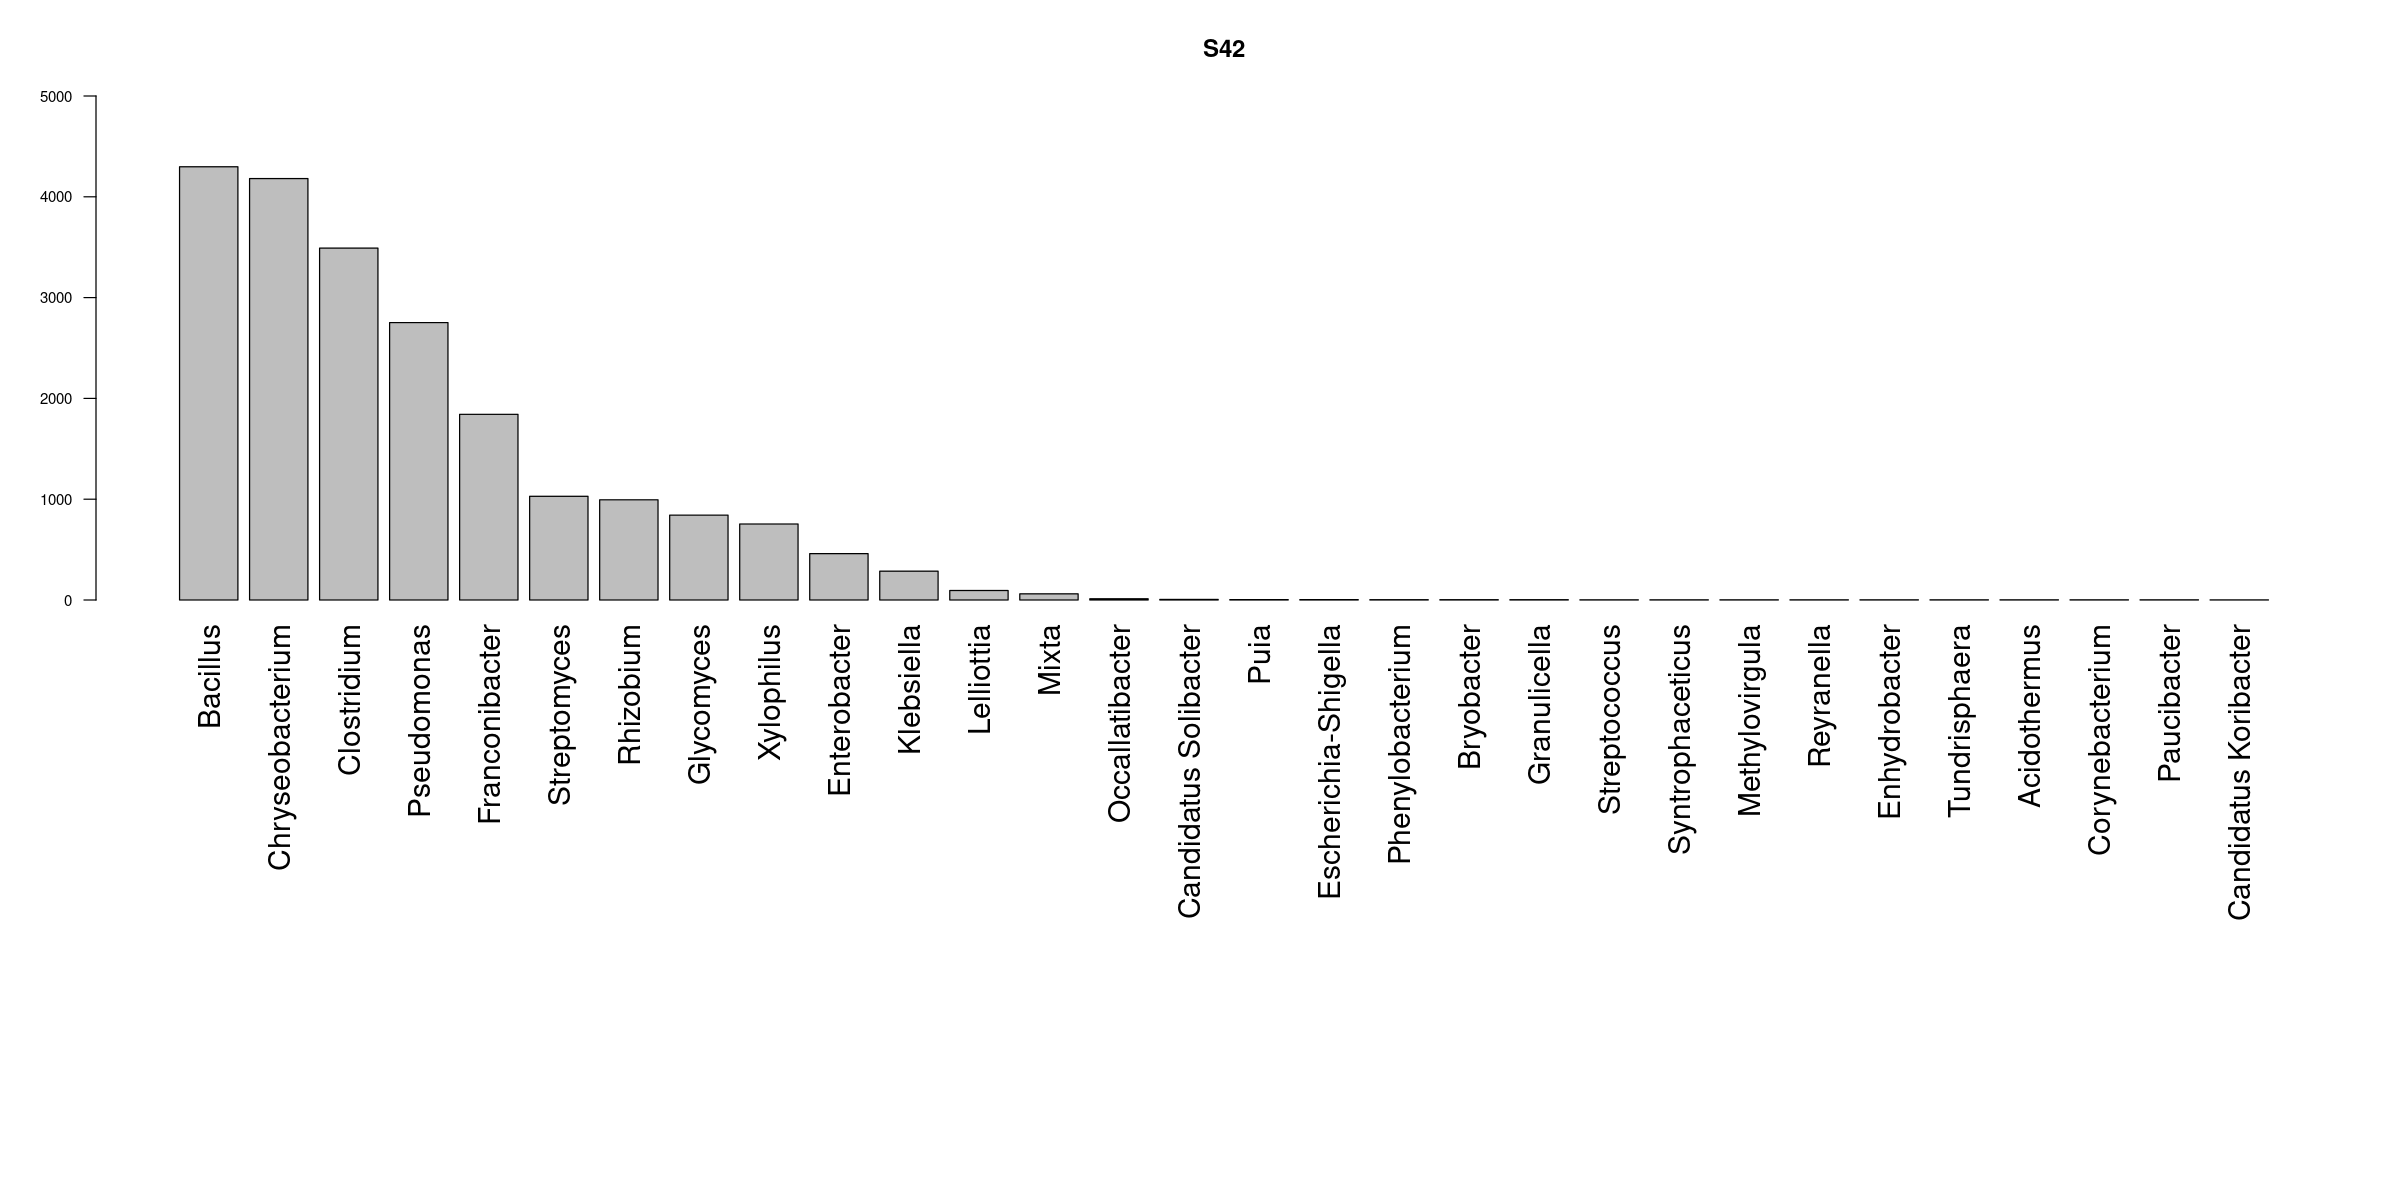

In [80]:
rankAb(ps.inTree.genus,"S42",ylimit=5000, ntax = 30)

[1] 55


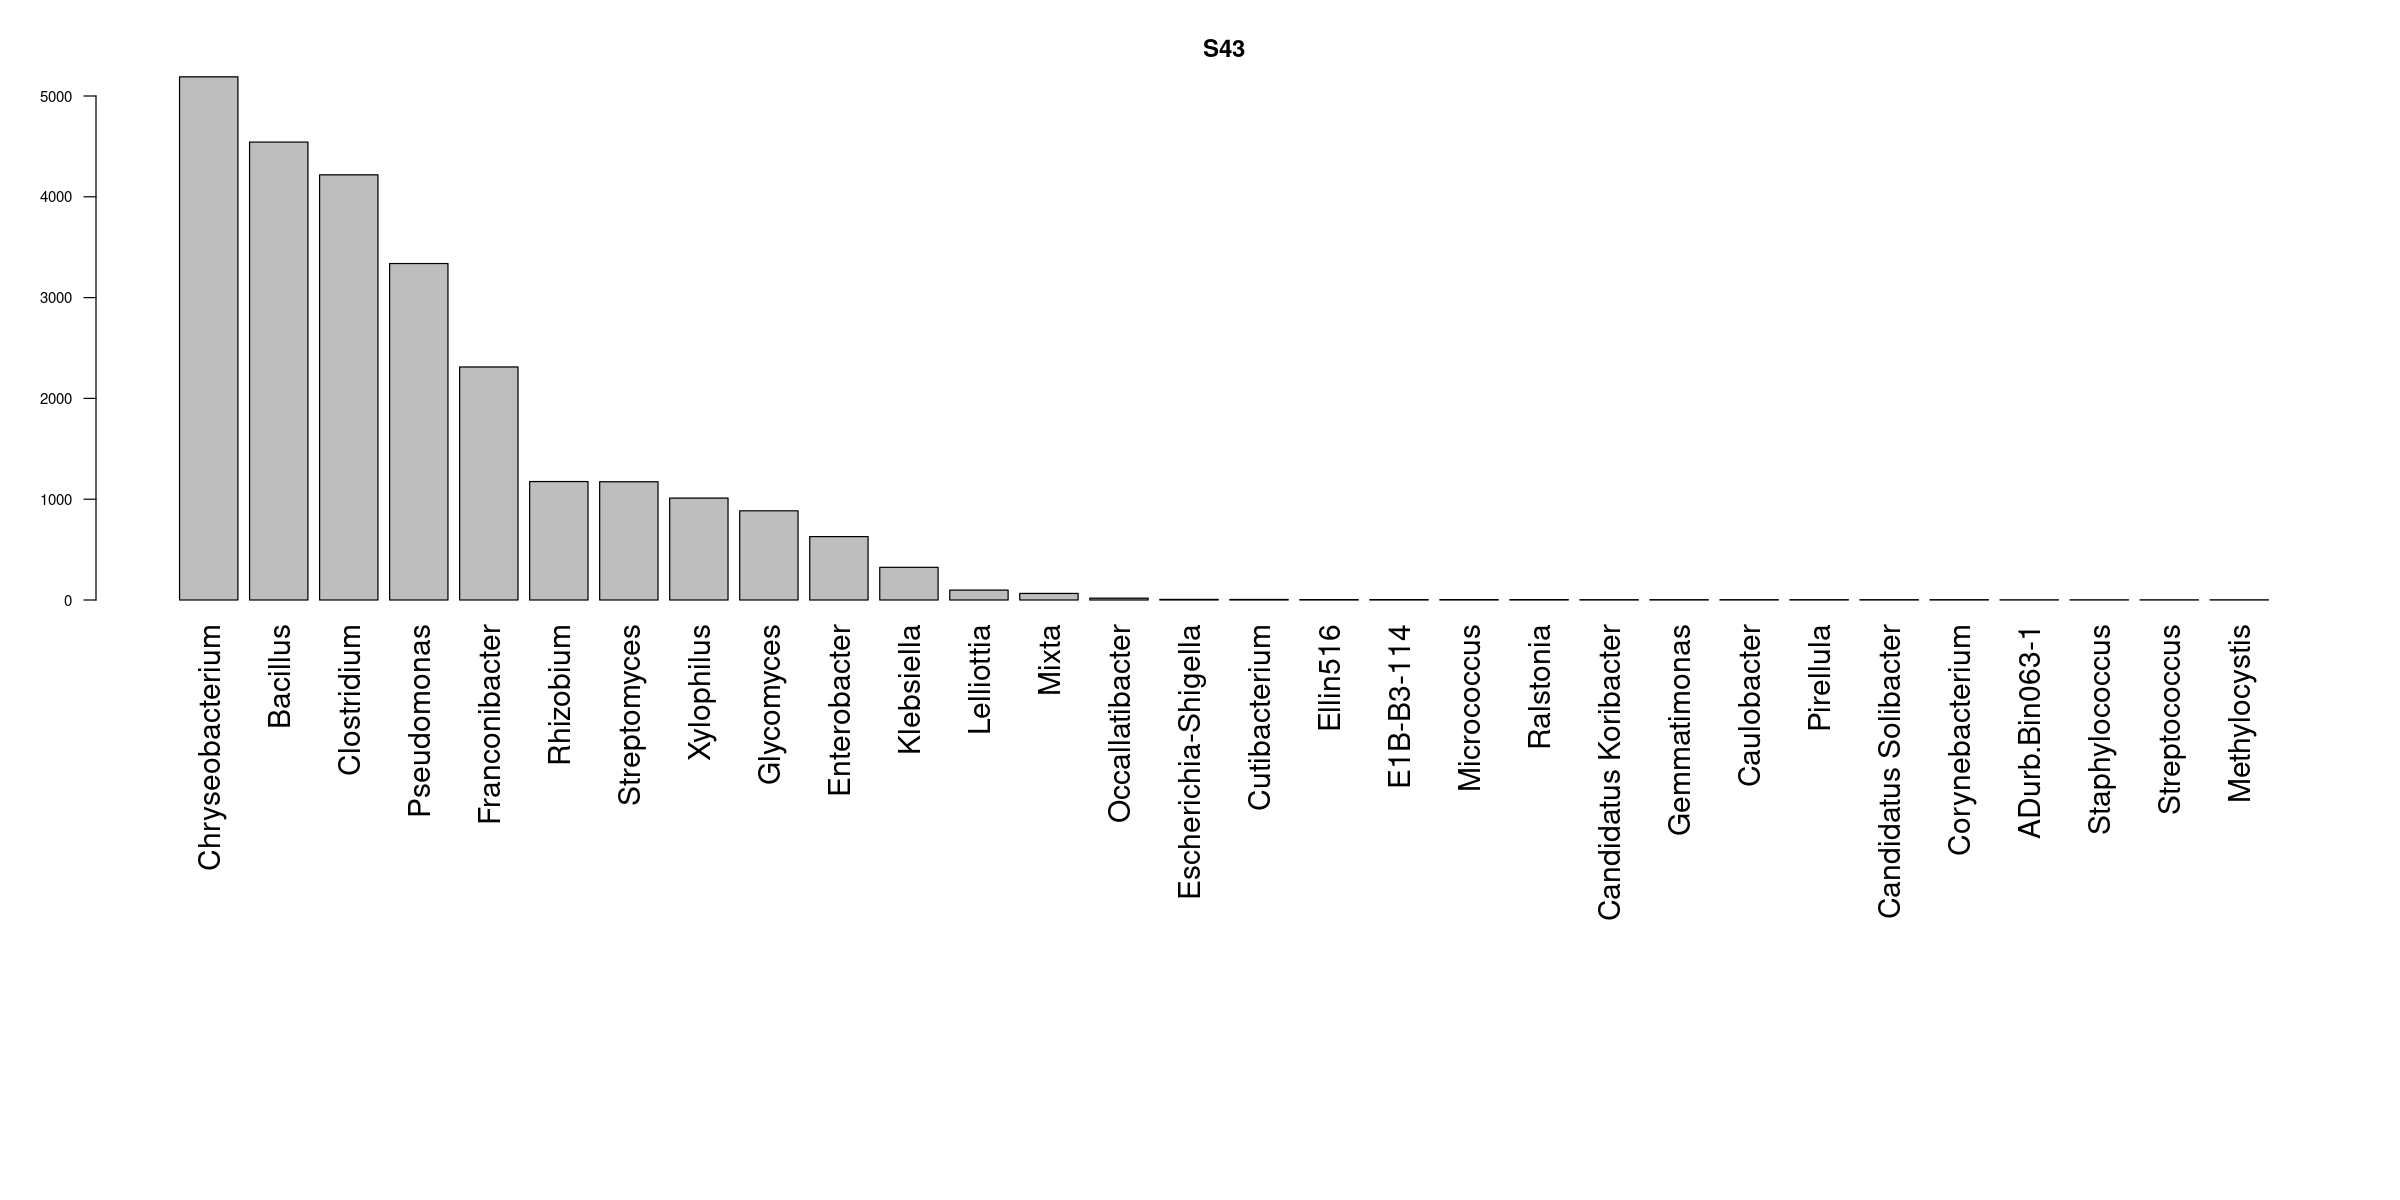

In [81]:
rankAb(ps.inTree.genus,"S43",ylimit=5000, ntax = 30)

In our raw ASV graphics above, we see very uneven abundances. *Variovorax* seems to be mostly lost, and the appearance of *Xylophilius*, which was not an intended member of the mock community. This seems to be related, because these two are both members of Comomonadaceae, perhaps this *Xylophilius* is the mis-identified *Variovorax*. It also seems like that *Enterobacter* was split into *Enterobacter* and *Klebsiella*.

But we don't really want to agglomerate by taxonomy, we will lose a lot of information, at least I think with the PICRUSTt2 pipeline. So back up, and let's make some decisions about OTU radius using our ASV-level mock controls:

<a id=adustOTUradius></a>
## Adjustment of OTU radius using controls.

We can use our mock community positive controls to tweak the overall OTU radius of our study. ASV level is the finest level resolution available to us, but we can see that it splits apart species that we put into our mock control. This may or may not represent actual biological diversity, but in addition we may want to accept some natural variation anyway. Ideally, I would like to use an OTU radius that recaptures all of the intended 11 species that we introduced into our mock commuinity DNA sample, but also a radius that doesn't split up these species into many sub-groups. 
Our mock community controls contained 11 different species:

| DSMZ name | (Sub)Phylum |
|  :--- | ---: |
|  Bacillus subtilis          | Bacillota            | 
|  Chryseobacterium luteum    | Bacteroidota         |  
|  Clostridium roseum         | Bacillota            |  
|  Enterobacter mori          | Gammaproteobacteria  |  
|  Franconibacter helveticus  | Gammaproteobacteria  |  
|  Glycomyces tenuis          | Actinomycetetota     |  
|  Pseudomonas fluorescens    | Gammaproteobacteria  |  
|  Pseudomonas putida         | Gammaproteobacteria  | 
|  Rhizobium endophyticum     | Alphaproteobacteria  | 
|  Streptomyces acidiscabies  | Actinomycetatota     | 
|  Variovorax guangxiensis    | Betaproteobacteria   |


Genomic DNA was extracted from each of these species, and added to the mock community samples in equimolar amounts, with the exception of *Pseudomonas putida*, which was added in a slightly lower volume (60%) than all the others.

In [96]:
getMCgenera <- function(sampleName, phyObj){
  sampleNo0filter <- get_taxa(phyObj, sampleName) > 0
  sampleNo0 <- get_taxa(phyObj, sampleName)[sampleNo0filter]
  sampleNo0 <- sort(sampleNo0, decreasing=TRUE)
  taxaNames=tax_table(phyObj)[ names(sampleNo0), "Genus"]
  names(sampleNo0) <- taxaNames
  mcShould <- c("Bacillus", "Chryseobacterium", "Clostridium", "Enterobacter", "Klebsiella", "Franconibacter", "Glycomyces", "Pseudomonas", "Rhizobium ", "Rhizobium", "Streptomyces", "Variovorax")
  possibleMCasvs <- rownames(taxaNames[taxaNames %in% mcShould])
  onlyMCasvs <- prune_taxa(possibleMCasvs, phyObj)
  realMCs <- get_taxa(onlyMCasvs, sampleName)
  genera <- realMCs
  names(genera) <- taxaNames[names(realMCs)]
  return(list(onlyMCasvs, realMCs, genera))
}

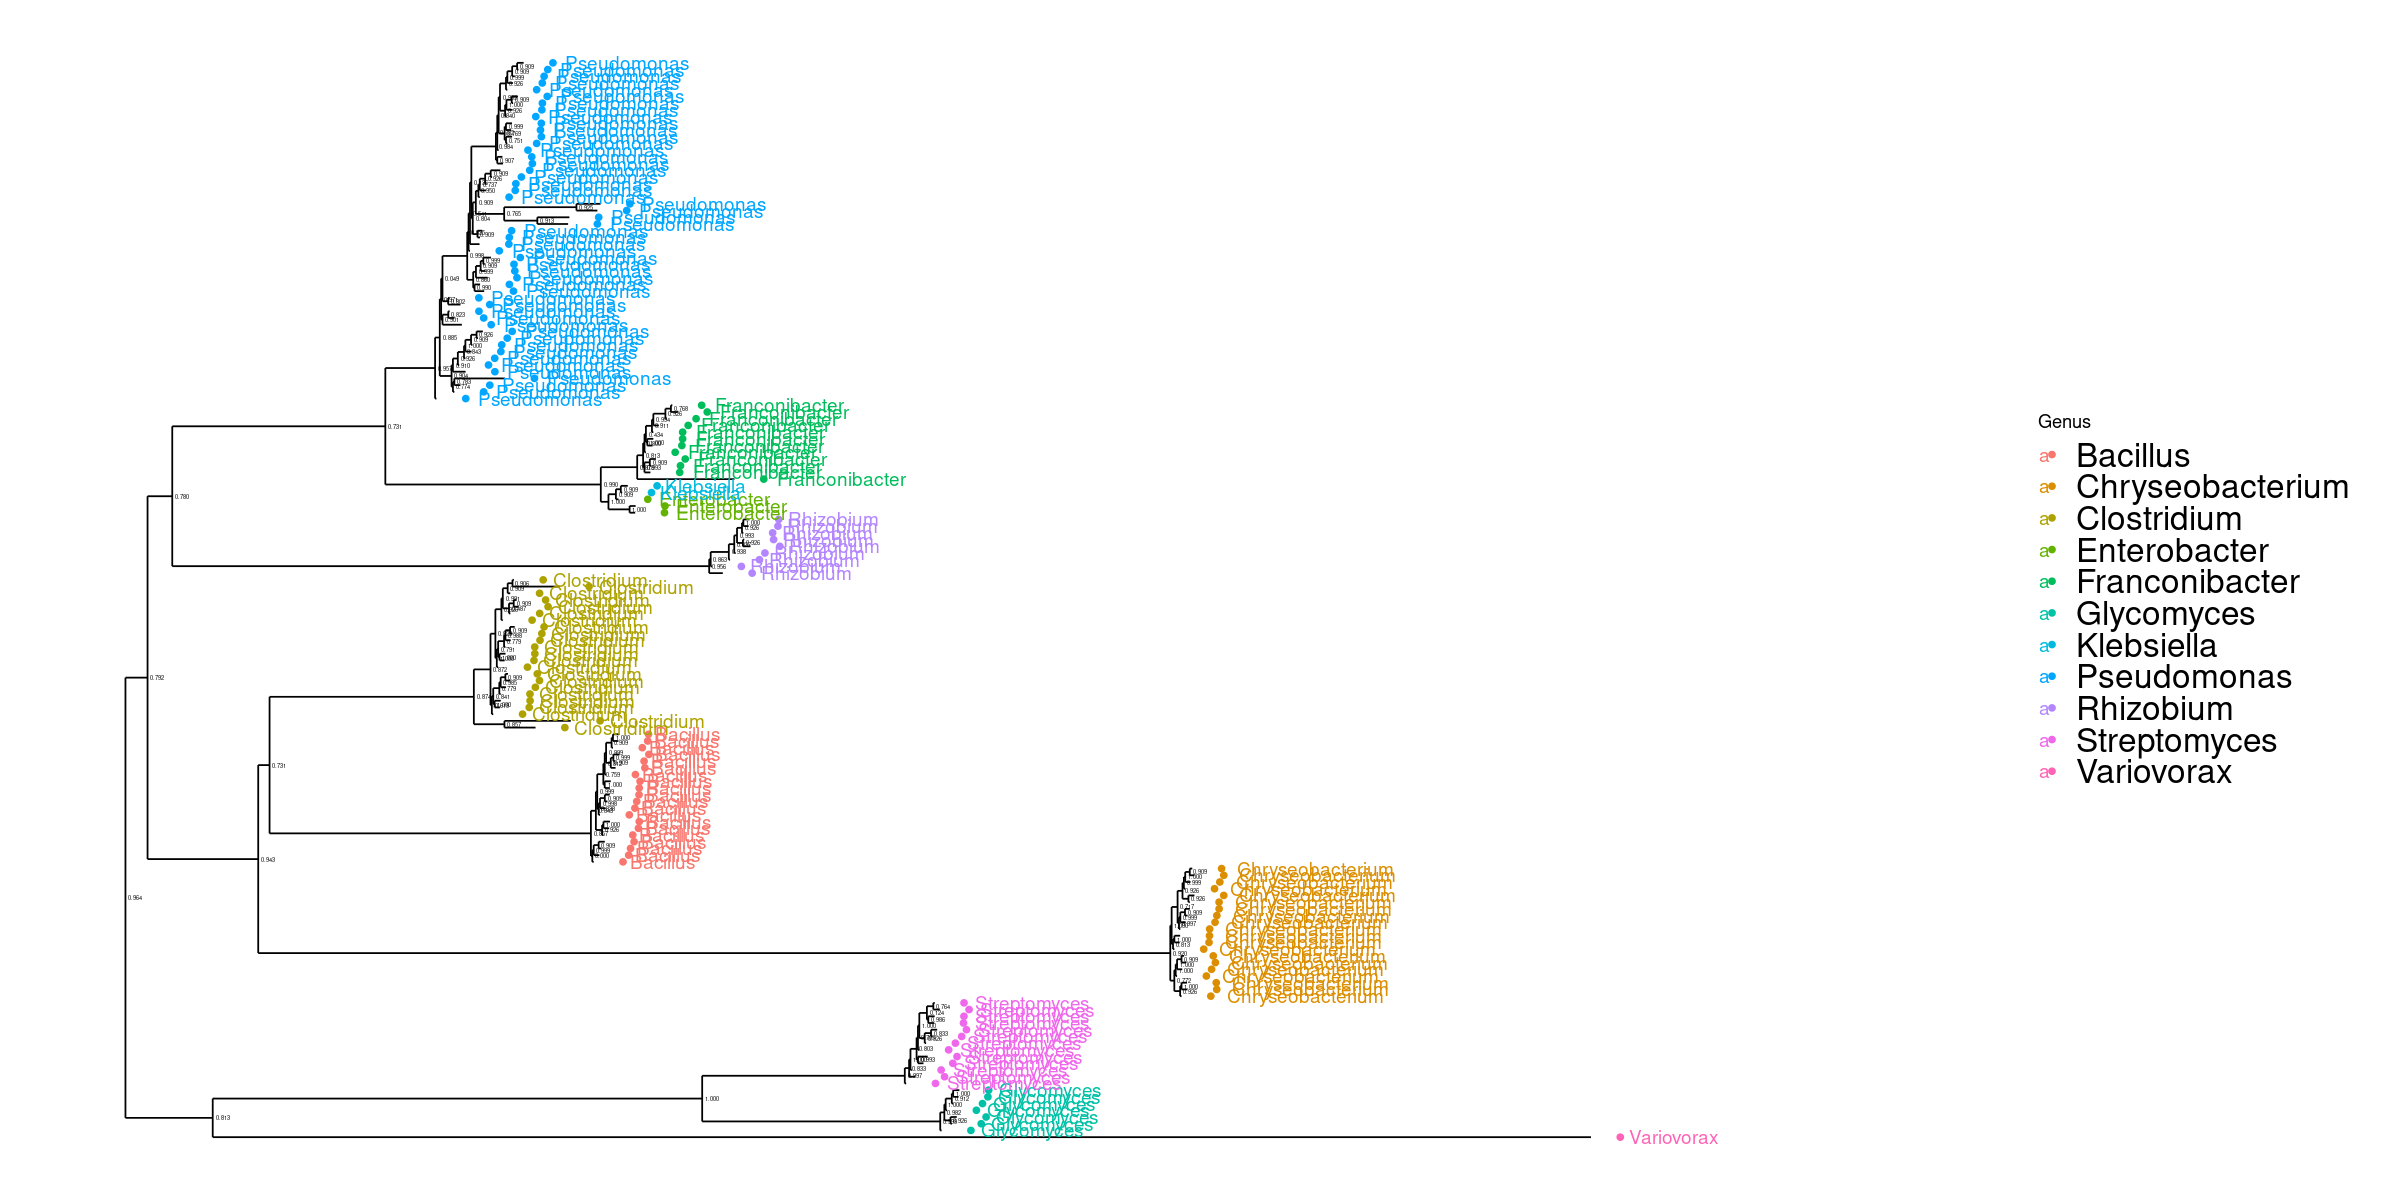

In [94]:
phyObj <- ps.inTree
sampleName <- "S43"
mcASVs <- names(getMCgenera(sampleName, phyObj)[[2]])
psControls = prune_samples(sampleName, phyObj)
psControls = prune_taxa(mcASVs, psControls)
plot_tree(psControls, color="Genus", label.tips="Genus", ladderize="left", text.size=4) + 
theme( legend.text = element_text(size=20)) 

That is hard to read, but essentially we see a lot of splitting of our mock community organisms at the ASV level. So some lumping is in order. However, one has to be careful to balance this with loss of information when ASVs get swallowed by other non-target ASVs if the otu radius is too large. We can test out different cophenetic distances to melt back our tree tips into otus. For example, H=0.05 :

In [97]:
ps05 <- tip_glom(ps.inTree, h=0.05)
phyObj <- ps05 
phyName <- deparse(substitute(ps05))

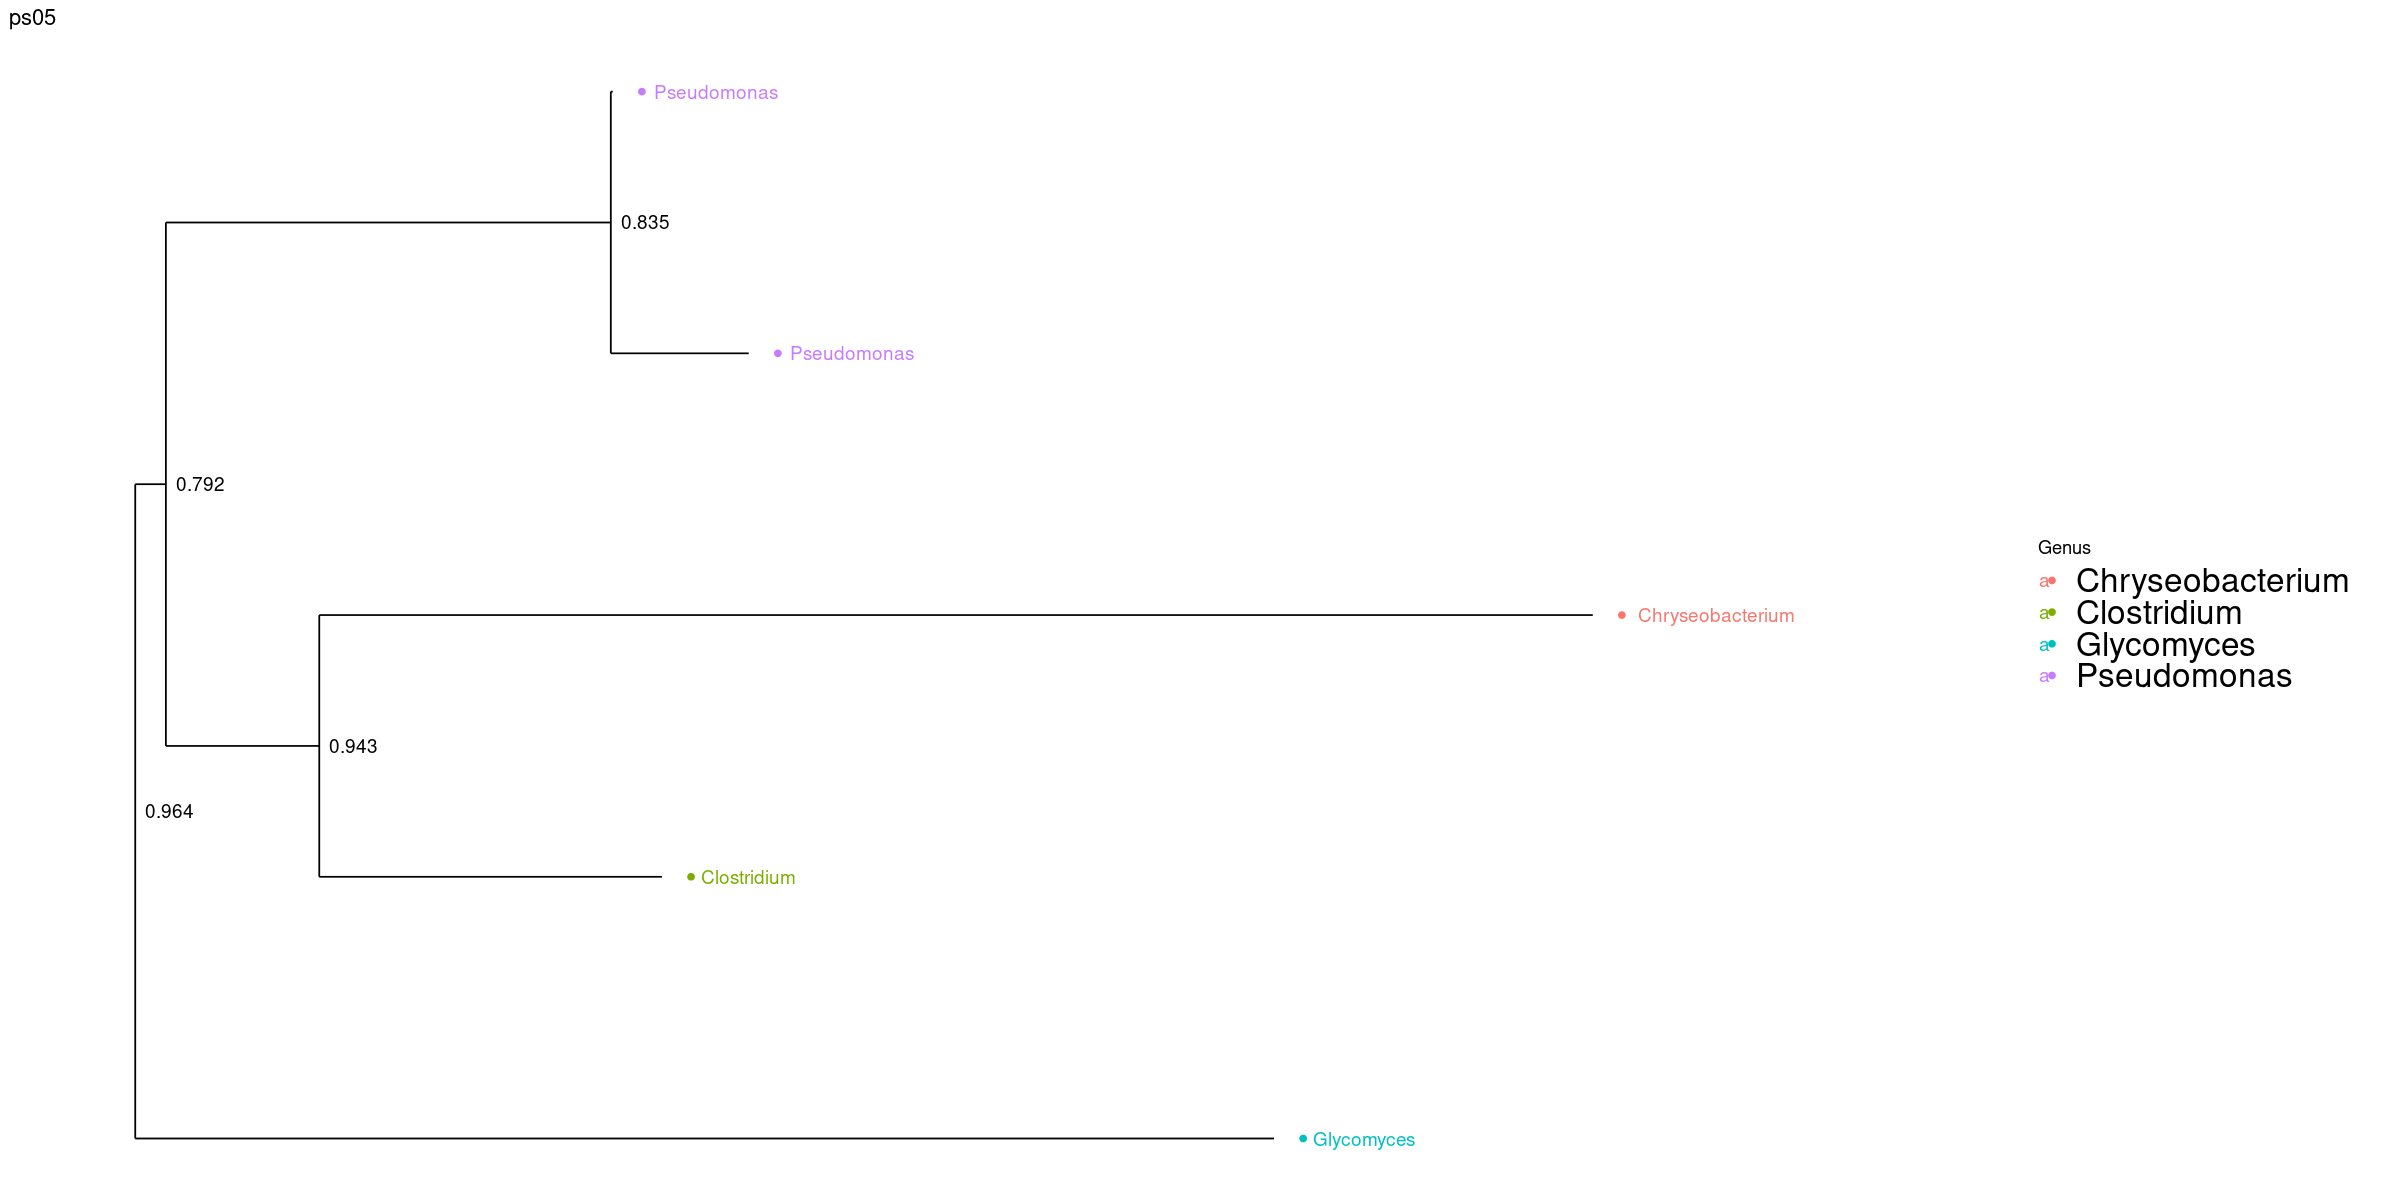

In [98]:
sampleName <- "S43"
mcASVs <- names(getMCgenera(sampleName, phyObj)[[2]])
psControls = prune_samples(sampleName, phyObj)
psControls = prune_taxa(mcASVs, psControls)
plot_tree(psControls, color="Genus", label.tips="Genus", ladderize="left", text.size=4) +
theme( legend.text = element_text(size=20))  +
ggtitle(phyName)

I tried numerous OTU radii, and arrived at a cophenetic distance of h = 0.007 as a compromise. As in, the largest radius in which almost all intended species from the mock community appear as at least one OTU. At this radius OTUs representing *Enterobacter* are still "swallowed" into other OTUs that are best identified as other non-member genera from other samples. However, other OTUs are beginning to be split into many different groups, creating "false" diversity in our sample. So I don't want a smaller OTU radius, and have to accept that some misidentification is occurring. 

In [91]:
ps007 <- tip_glom(ps.inTree, h=0.007)

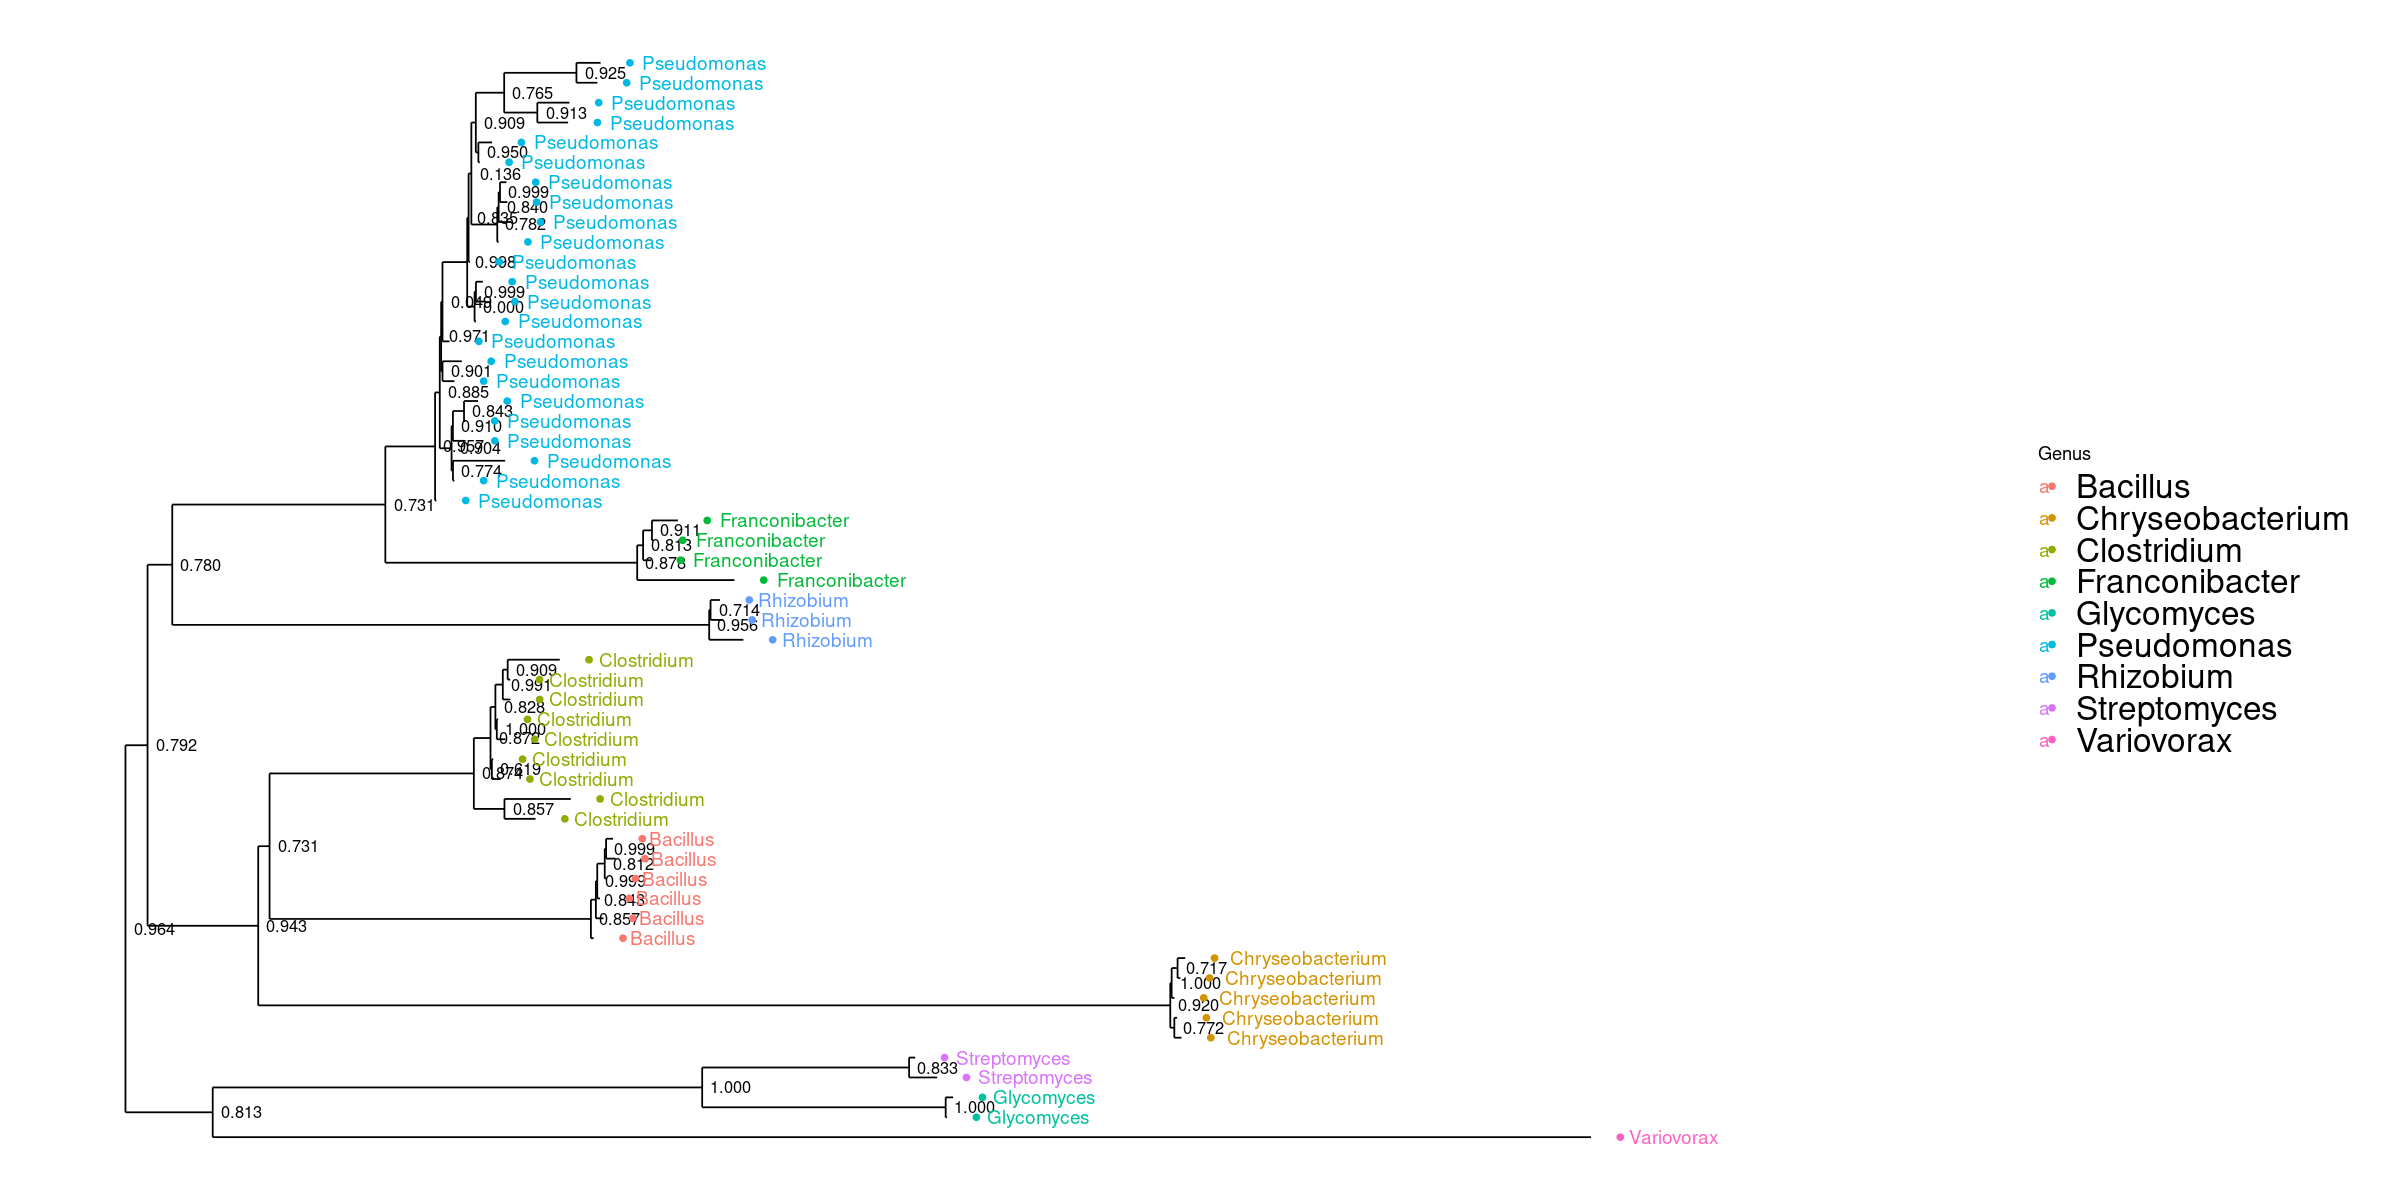

In [95]:
phyObj <- ps007
sampleName <- "S43"
mcASVs <- names(getMCgenera(sampleName, phyObj)[[2]])
psControls = prune_samples(sampleName, phyObj)
psControls = prune_taxa(mcASVs, psControls)
plot_tree(psControls, color="Genus", label.tips="Genus", ladderize="left", text.size=4) + 
theme( legend.text = element_text(size=20)) 

<a id=contamination></a>
## Reducing contamination using controls

We see evidence of laboratory contamination in our positive in the form of many low-abundance OTUs that were not intended members of the mock communities. Also in our two negative controls (pure-water):

[1] 423


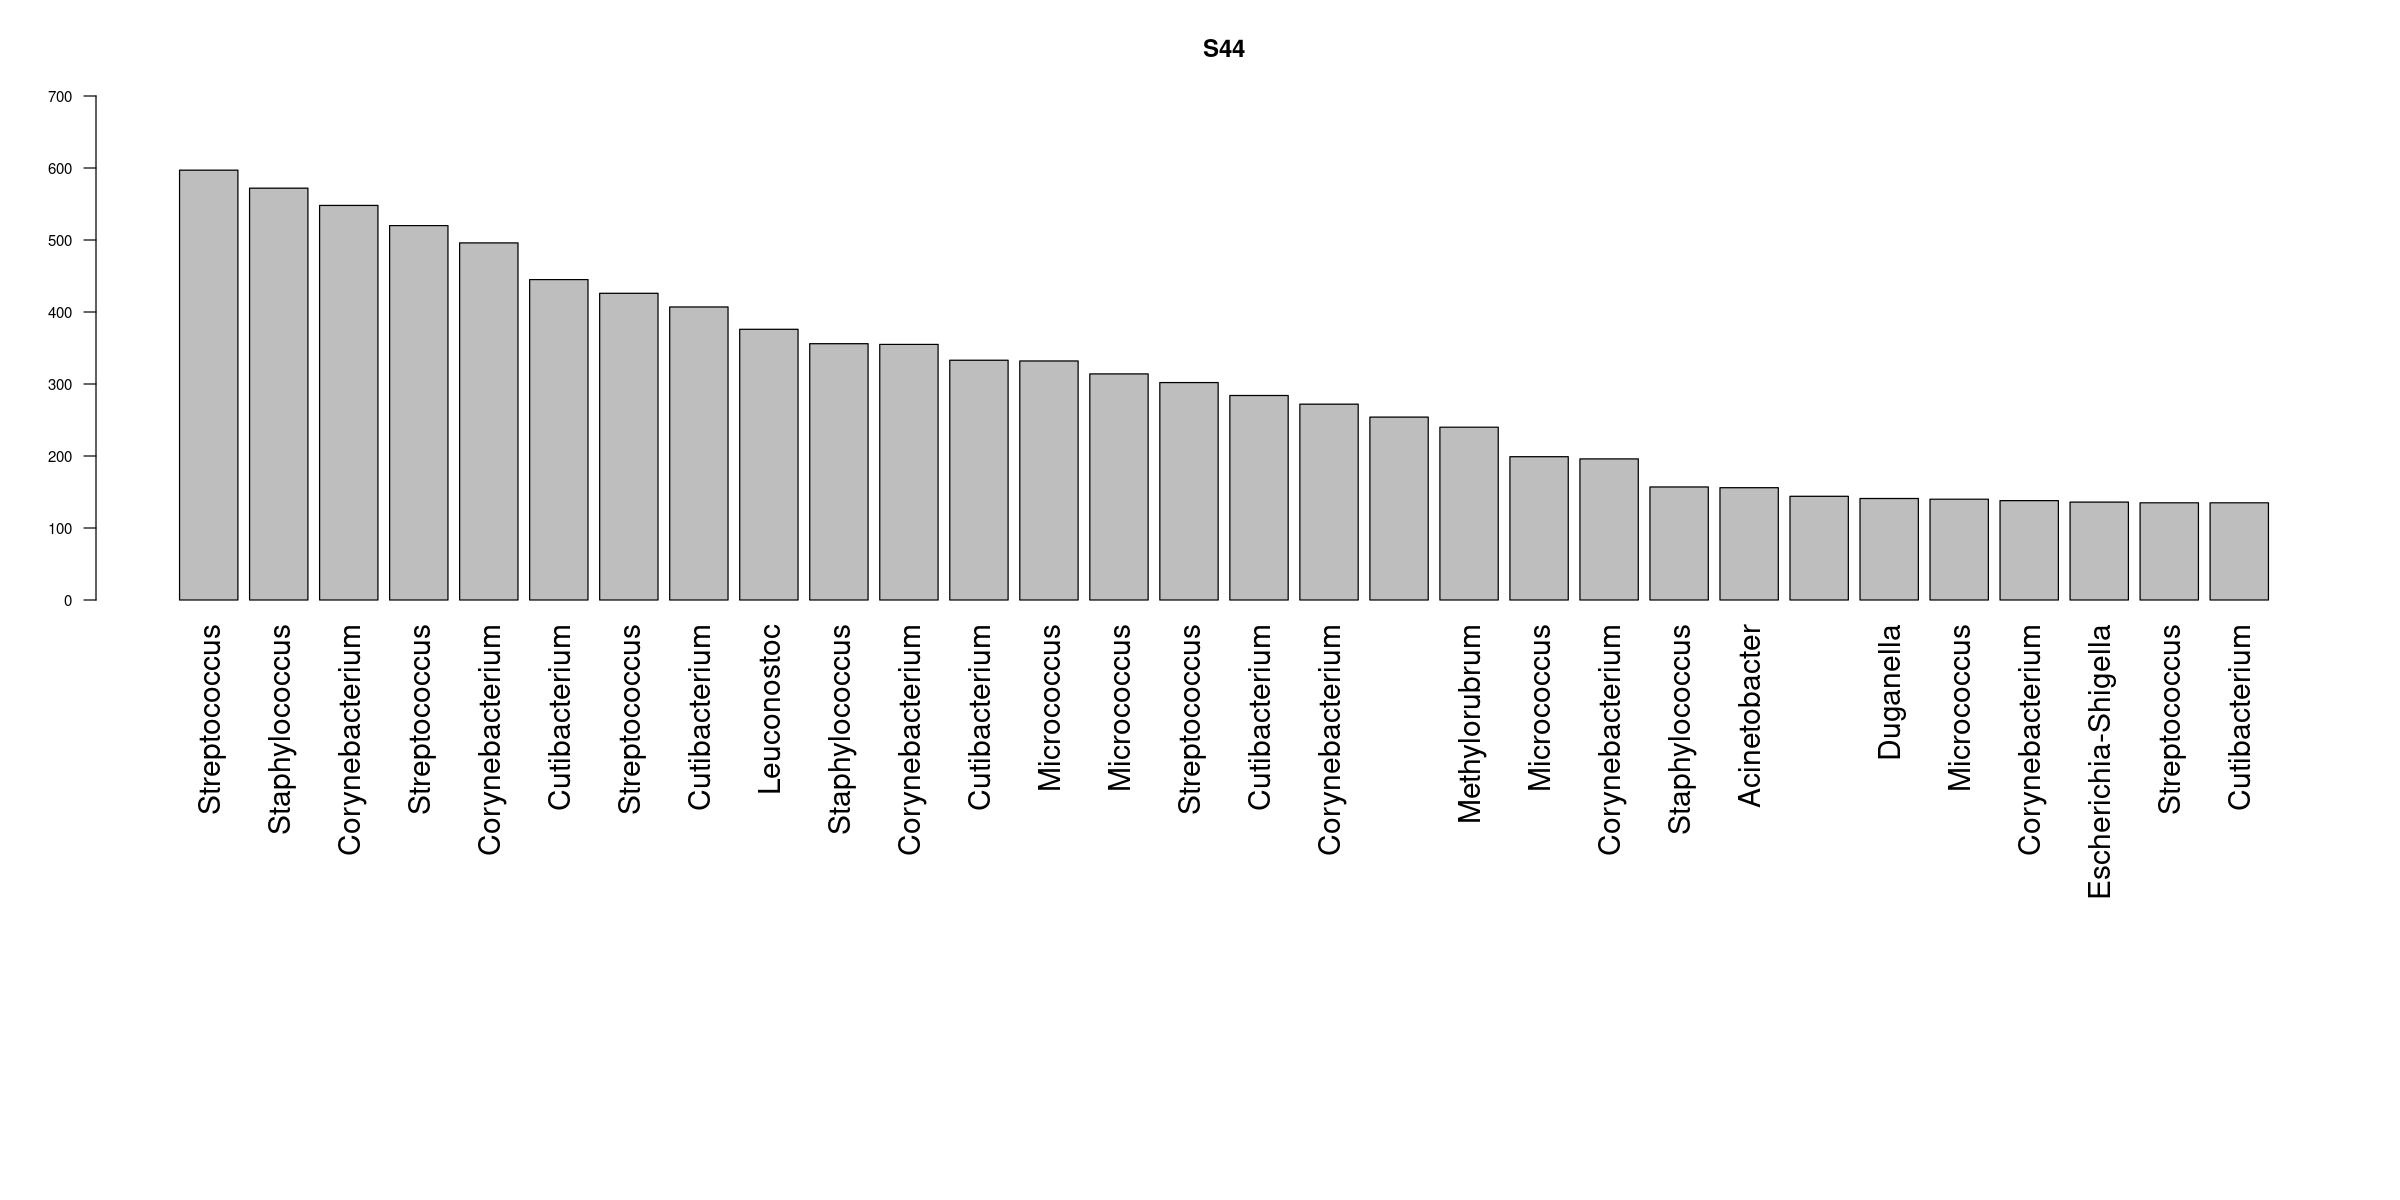

In [106]:
rankAb(ps007,"S44",ylimit=700, ntax = 30)

[1] 236


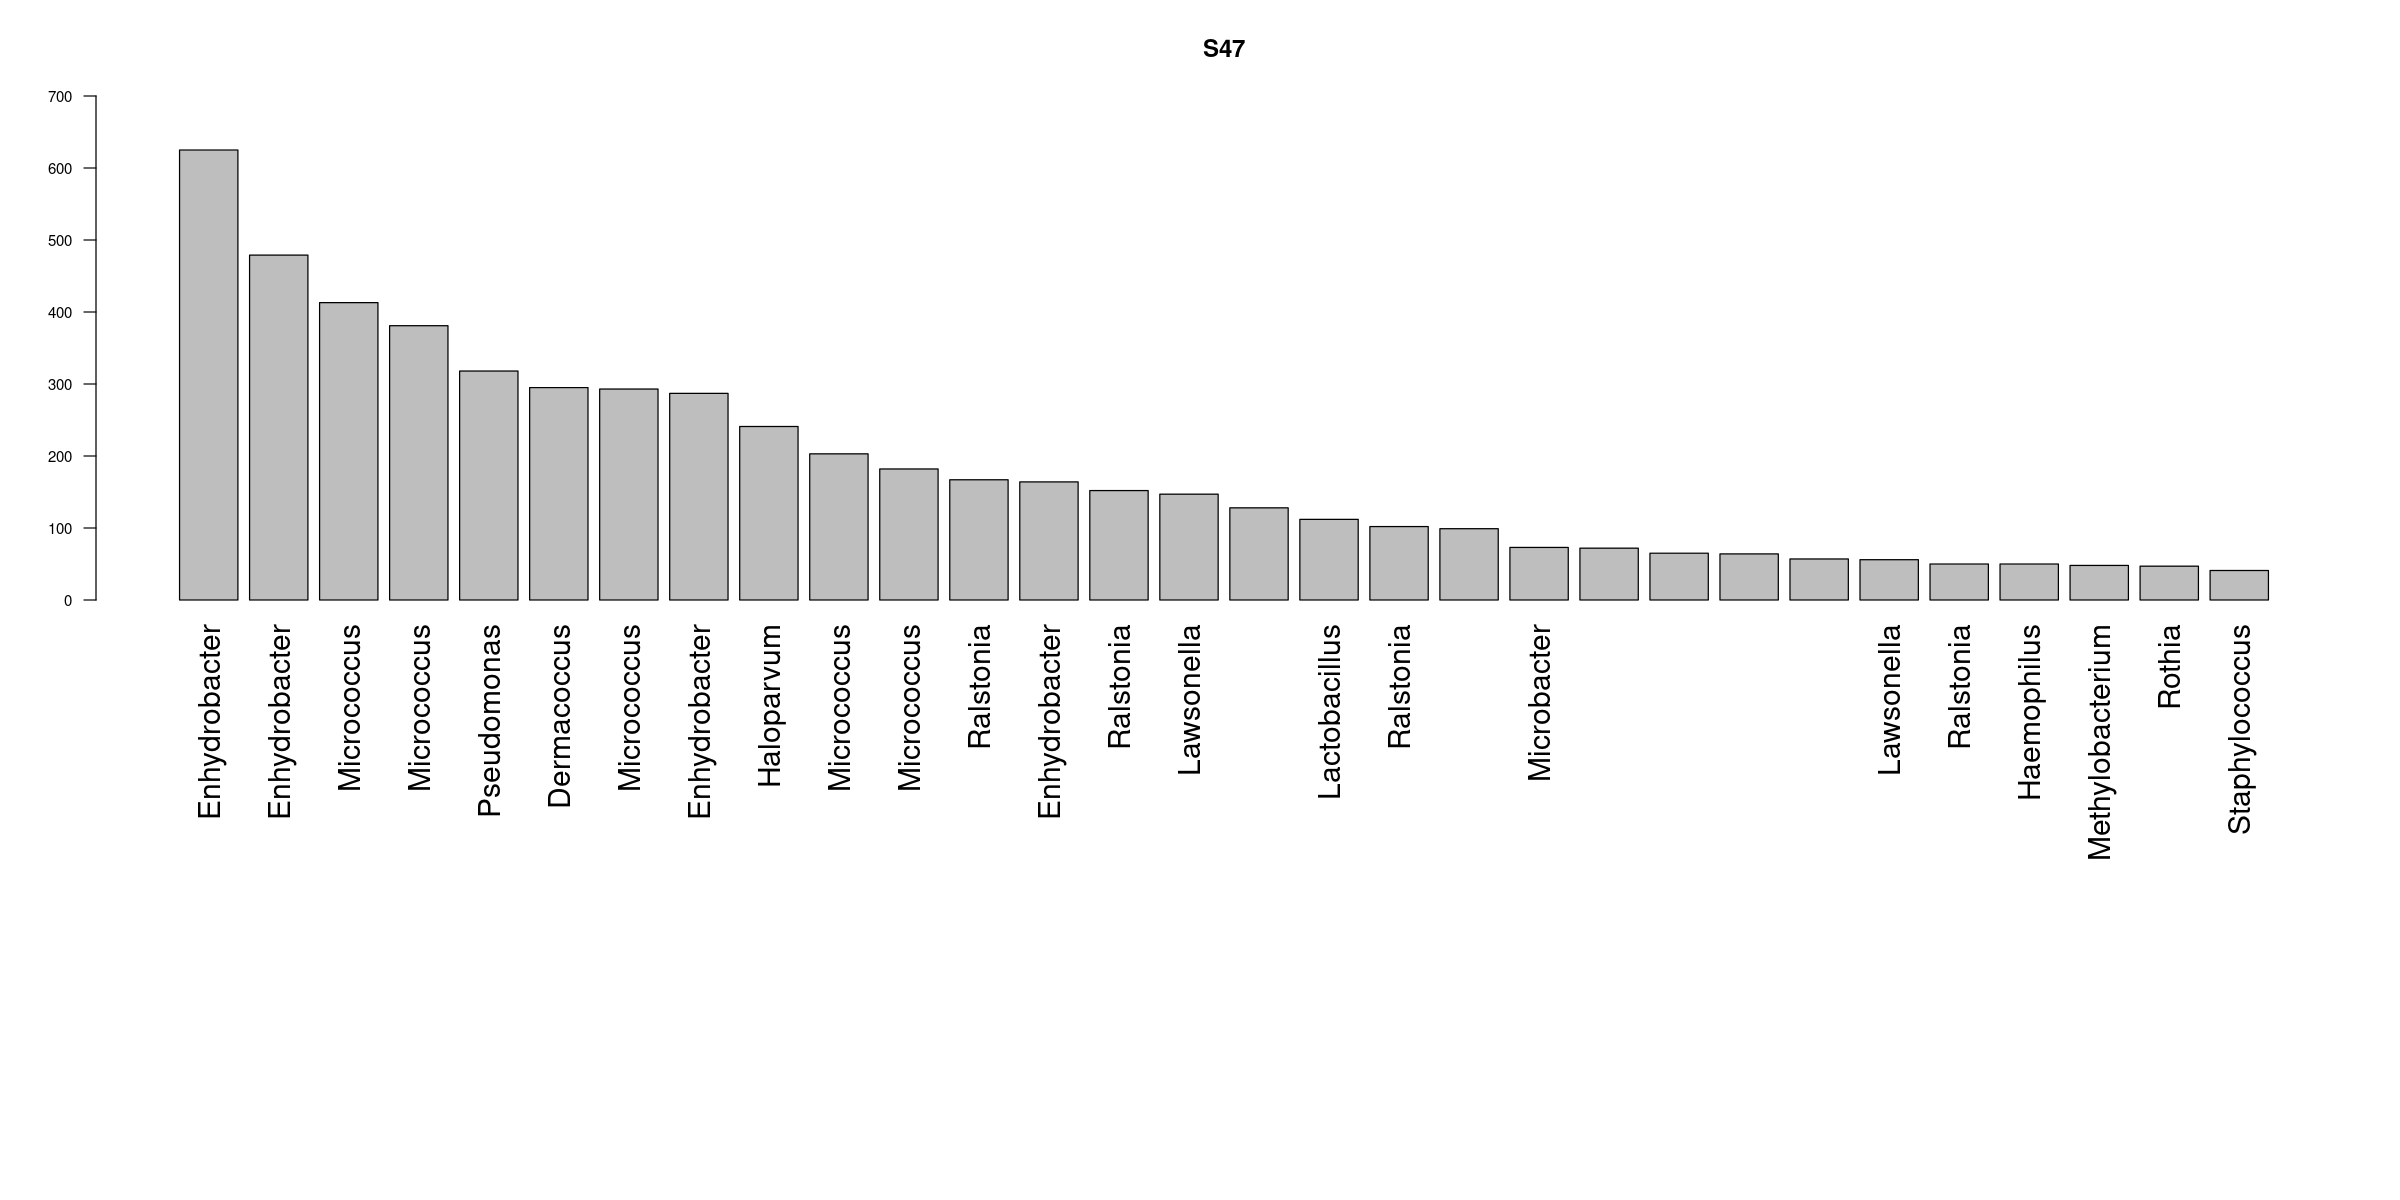

In [107]:
rankAb(ps007,"S47",ylimit=700, ntax = 30)

Most of these are common lab contaminants. The only unusual one is Enhydrobacter, which apparently is a rare aquatic anaerobe. The reference sequences for these are:

In [108]:
aa <- subset_taxa(ps007, Genus == "Enhydrobacter")
head(as.data.frame(refseq(aa)))

,x
,<chr>
ASV1255,TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGCTCATTAAGTCACATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATGTGATACTGGTGGTGCTAGAATATGTGAGAGGGAAGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCTTCCTGGCATAATATTGACACTGAGATTCGAAAGCGTGGGTAGCAAACAGGATTAGAAACCCCTGTAGTCC
ASV2041,TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGCTCATTAAGTCACATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATGTGATACTGGTGGTGCTAGAATATGTGAGAGGGAAGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCTTCCTGGCATAATATTGACACTGAGATTCGAAAGCGTGGGTAGCAAACAGGATTAGAAACCCGTGTAGTCC
ASV1036,TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGCTCATTAAGTCACATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATGTGATACTGGTGGTGCTAGAATATGTGAGAGGGAAGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCTTCCTGGCATAATATTGACACTGAGATTCGAAAGCGTGGGTAGCAAACAGGATTAGAAACCCTCGTAGTCC
ASV1155,TACAGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGCTCATTAAGTCACATGTGAAATCCCCGGGCTTAACCTGGGAACTGCATGTGATACTGGTGGTGCTAGAATATGTGAGAGGGAAGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGATGGCGAAGGCAGCTTCCTGGCATAATATTGACACTGAGATTCGAAAGCGTGGGTAGCAAACAGGATTAGATACCCTCGTAGTCC


A manual blast search confirms, this is very closely related to a uncultured OTU observed from skin that was identified using an automated pipeline to Enhydrobacter. So yeah, a contaminant. 

We also know that very abundant organisms tend to "index-hop", or appear in other samples, due to proximity on flow cells and illumina camera errors. To avoid the possibility that we introduced unwanted new organisms into our study via our mock communities, we'll need to subtract the presence of members of our mock community from the ecological samples.

Etc. Etc. So let's clean up. Basically, we will subtract all the maximum abundances from our controls (positive and negative) from the rest of our samples:

In [122]:
## remove maximum values from any OTU observed in controls
controlsNotEcoRep <- c("Mock_community_1","Mock_community_2","Negative_PCR","Moss_Negative_PCR")
ps007.controls <- subset_samples(physeq=ps007, Subsite %in% controlsNotEcoRep)
aa <- otu_table(ps007.controls)
bb <- otu_table(ps007)
controlAbus <- apply(aa, 2, max)
cc <- t(t(bb) - controlAbus)
cc[cc < 0 ] <- 0
ps007_cleaned <- ps007
otu_table(ps007_cleaned) <- cc

## get rid of controls and low abundance samples:
ps007_cleaned <- subset_samples(ps007_cleaned, EcoCont != "Control") 
## and get rid of the low abundance samples:
ps007_cleaned <- prune_samples(sample_sums(ps007_cleaned)>=1000, ps007_cleaned)

<a id=transformation></a>
## Adjustment of abundances (transformations)

We see some very large differences in abundances in our mock communities, especially if we agglomerate by to genus level:


In [100]:
ps.007.genus <- tax_glom(ps007, taxrank="Genus")

[1] 51


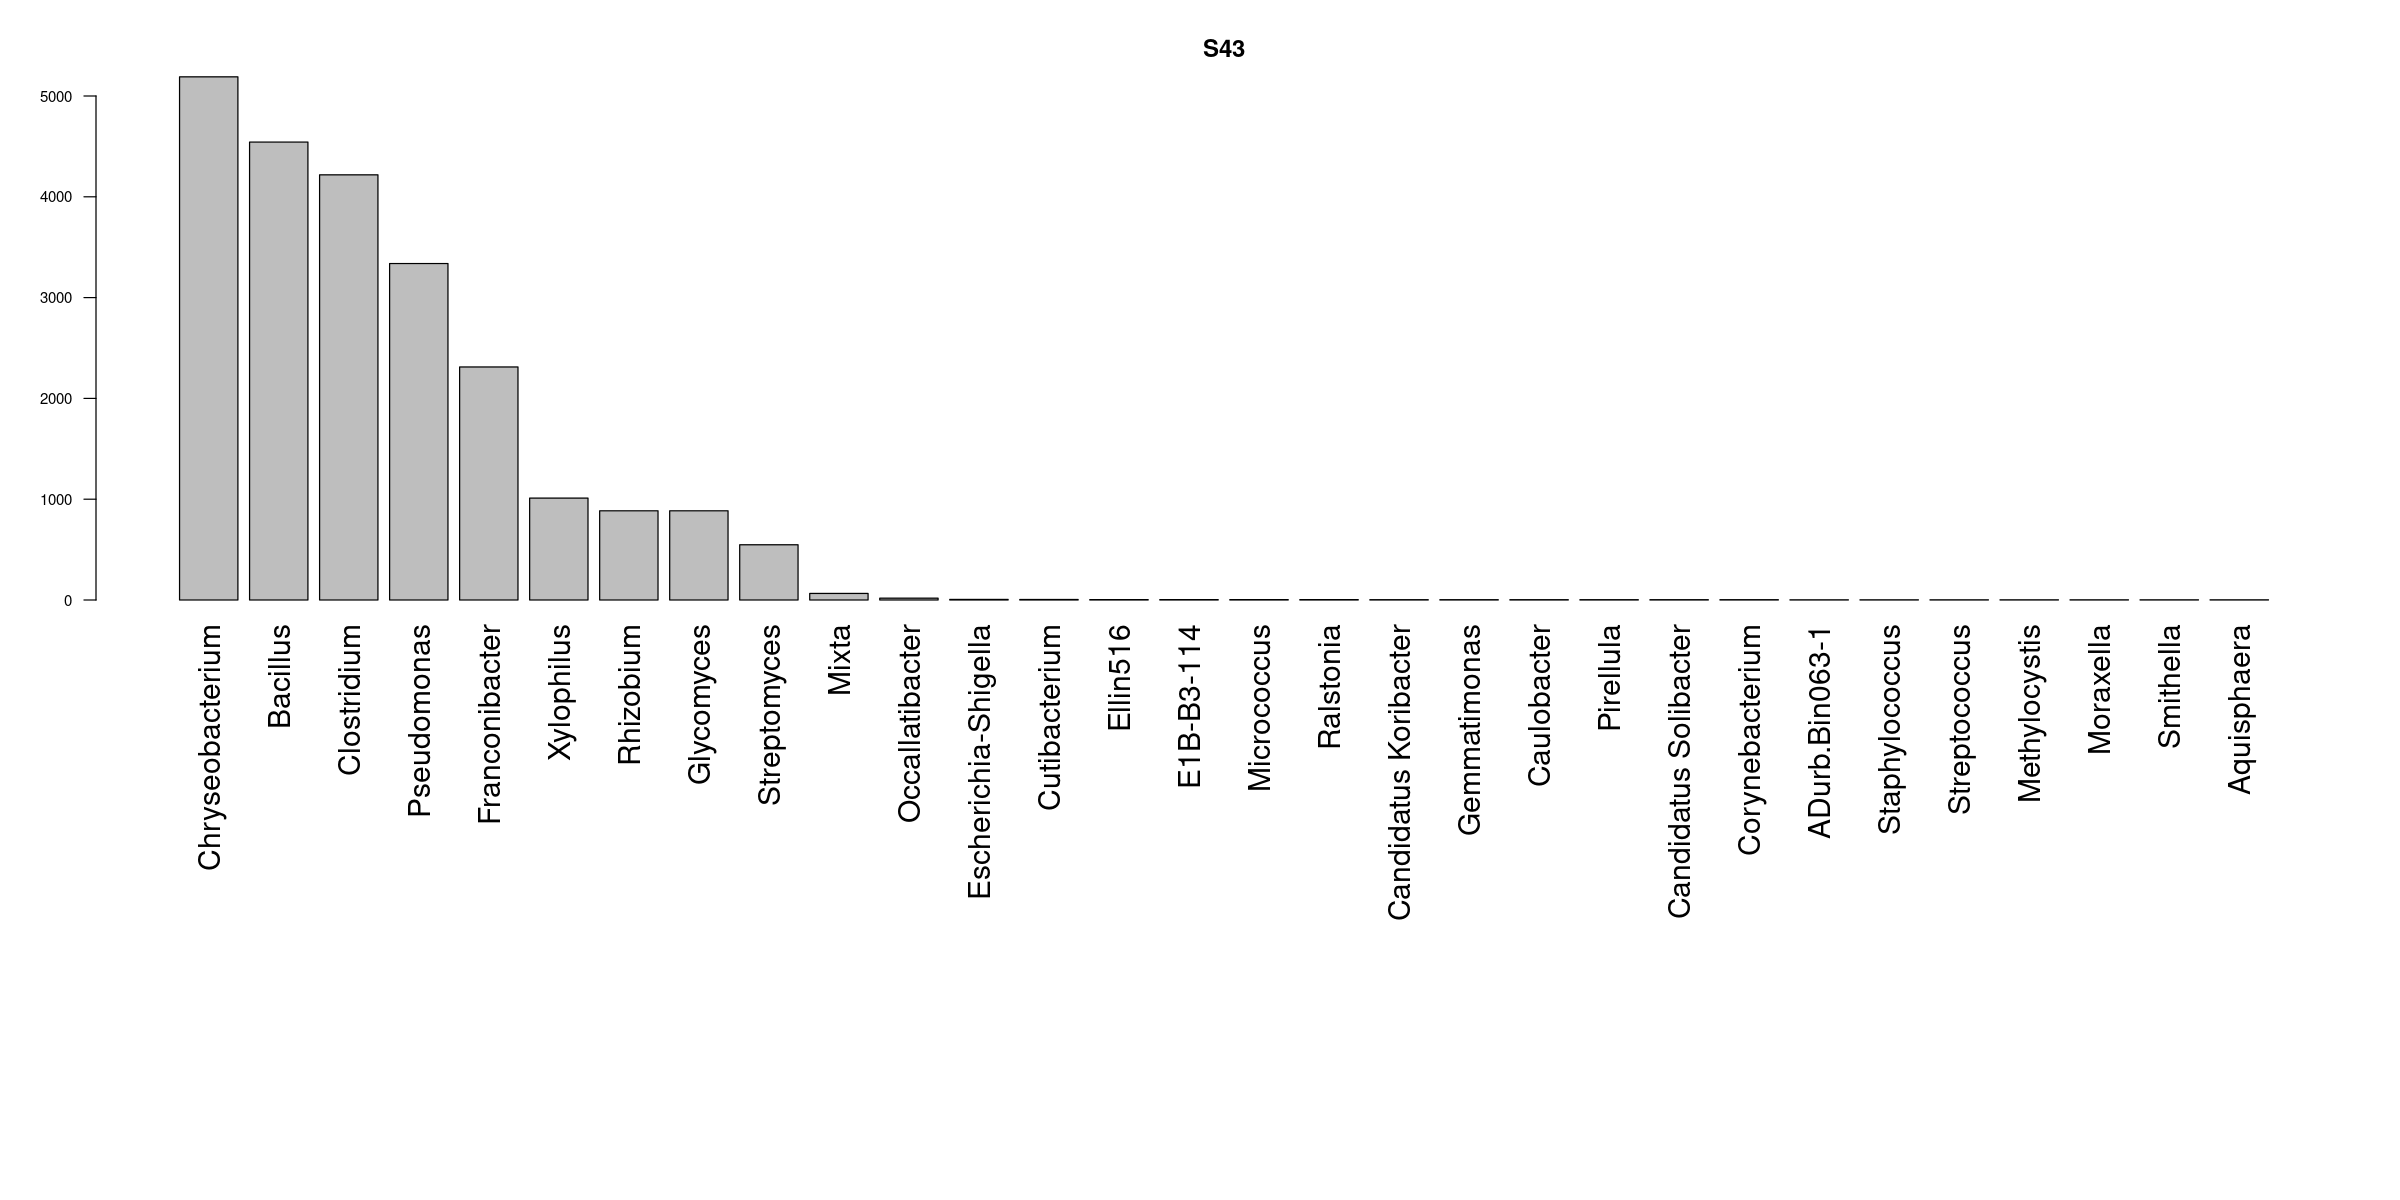

In [101]:
rankAb(ps.007.genus,"S43",ylimit=5000, ntax = 30)

Though very imperfect, as microbiologists we have to use DNA to observe the presence and abundance of unculturable organisms. But even with ~equal equimolar DNA from each organism, we see dramatic differences in read abundances. This is due to the numerous other sources of bias in our pipelines: differential genome size and 16S copy-number, PCR amplification bias, sequencer error, etc, etc. We cannot correct for all these, we can only adjust backward now, to the original --probably incorrect -- model, that `moles of DNA ~ abundance of microbial cells`. 

Given that, let's take the square root of these abundances, in the hope of flattening artificial hyper-abundances, and then convert to relative abundance by sample:

In [128]:
ps007_sqrt <- transform_sample_counts(ps007, sqrt)
ps007_sqrt_genus <- tax_glom(ps007_sqrt, taxrank="Genus") ## for comparison to above

Comparing the non-glommed data (OTUs not combined to genus)...Here is the untransformed, unglommed mock community S43 (left) compared to transformed, unglommed S43 (right):

[1] 252
[1] 252


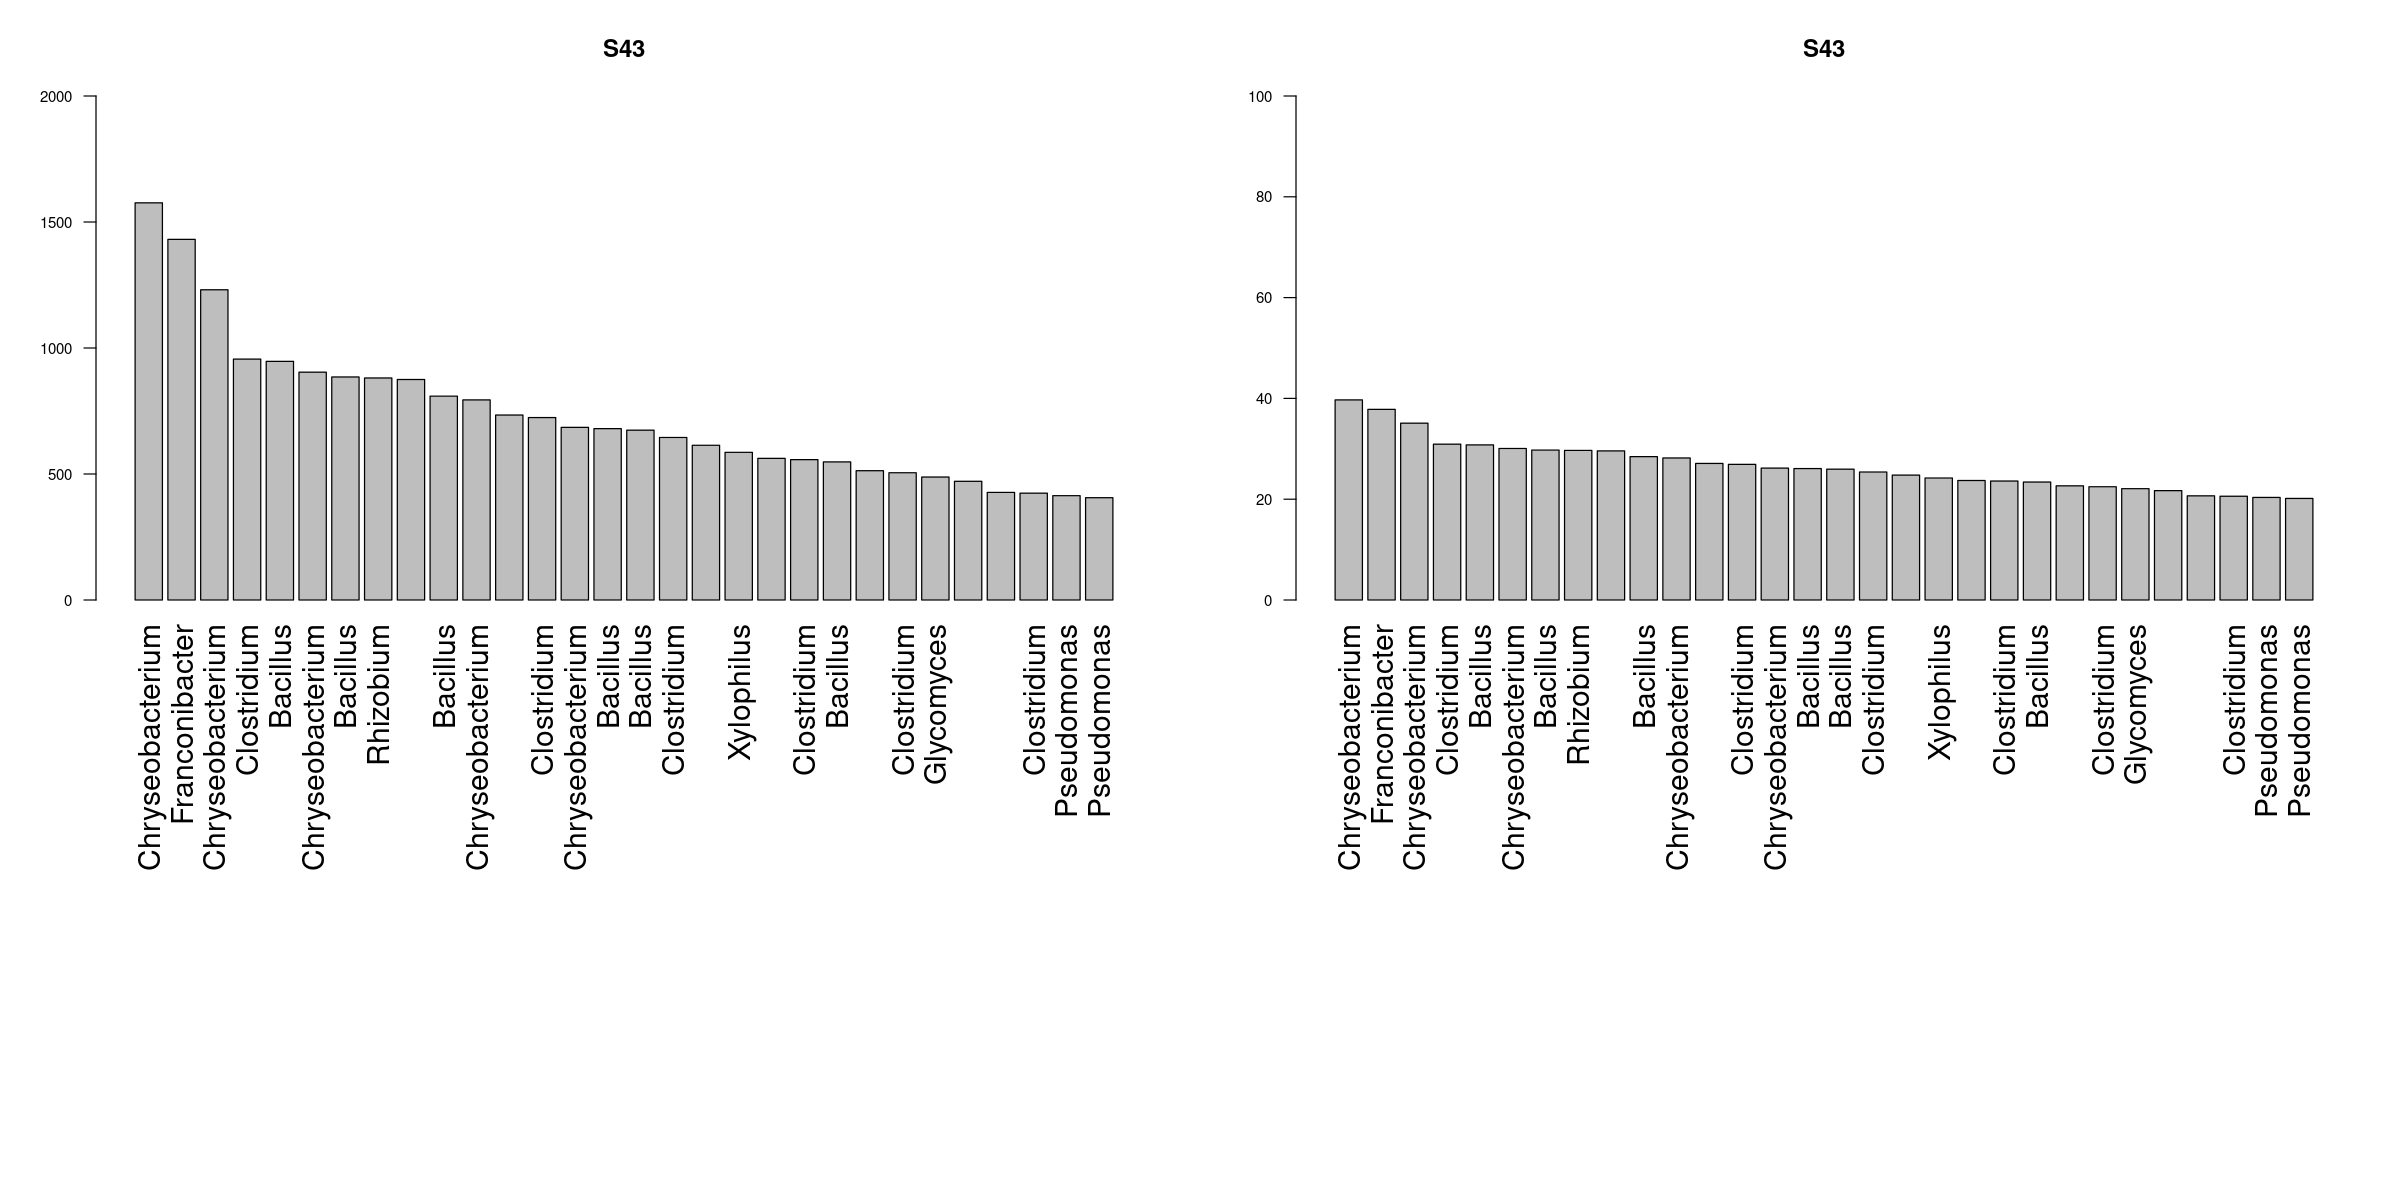

In [131]:
par(mfrow = c(1,2))
rankAb(ps007, "S43", ylimit=2000, ntax=30)
rankAb(ps007_sqrt, "S43", ylimit=100, ntax=30)

And comparing before and after square-root transformation of genus-glommed data:

[1] 51
[1] 51


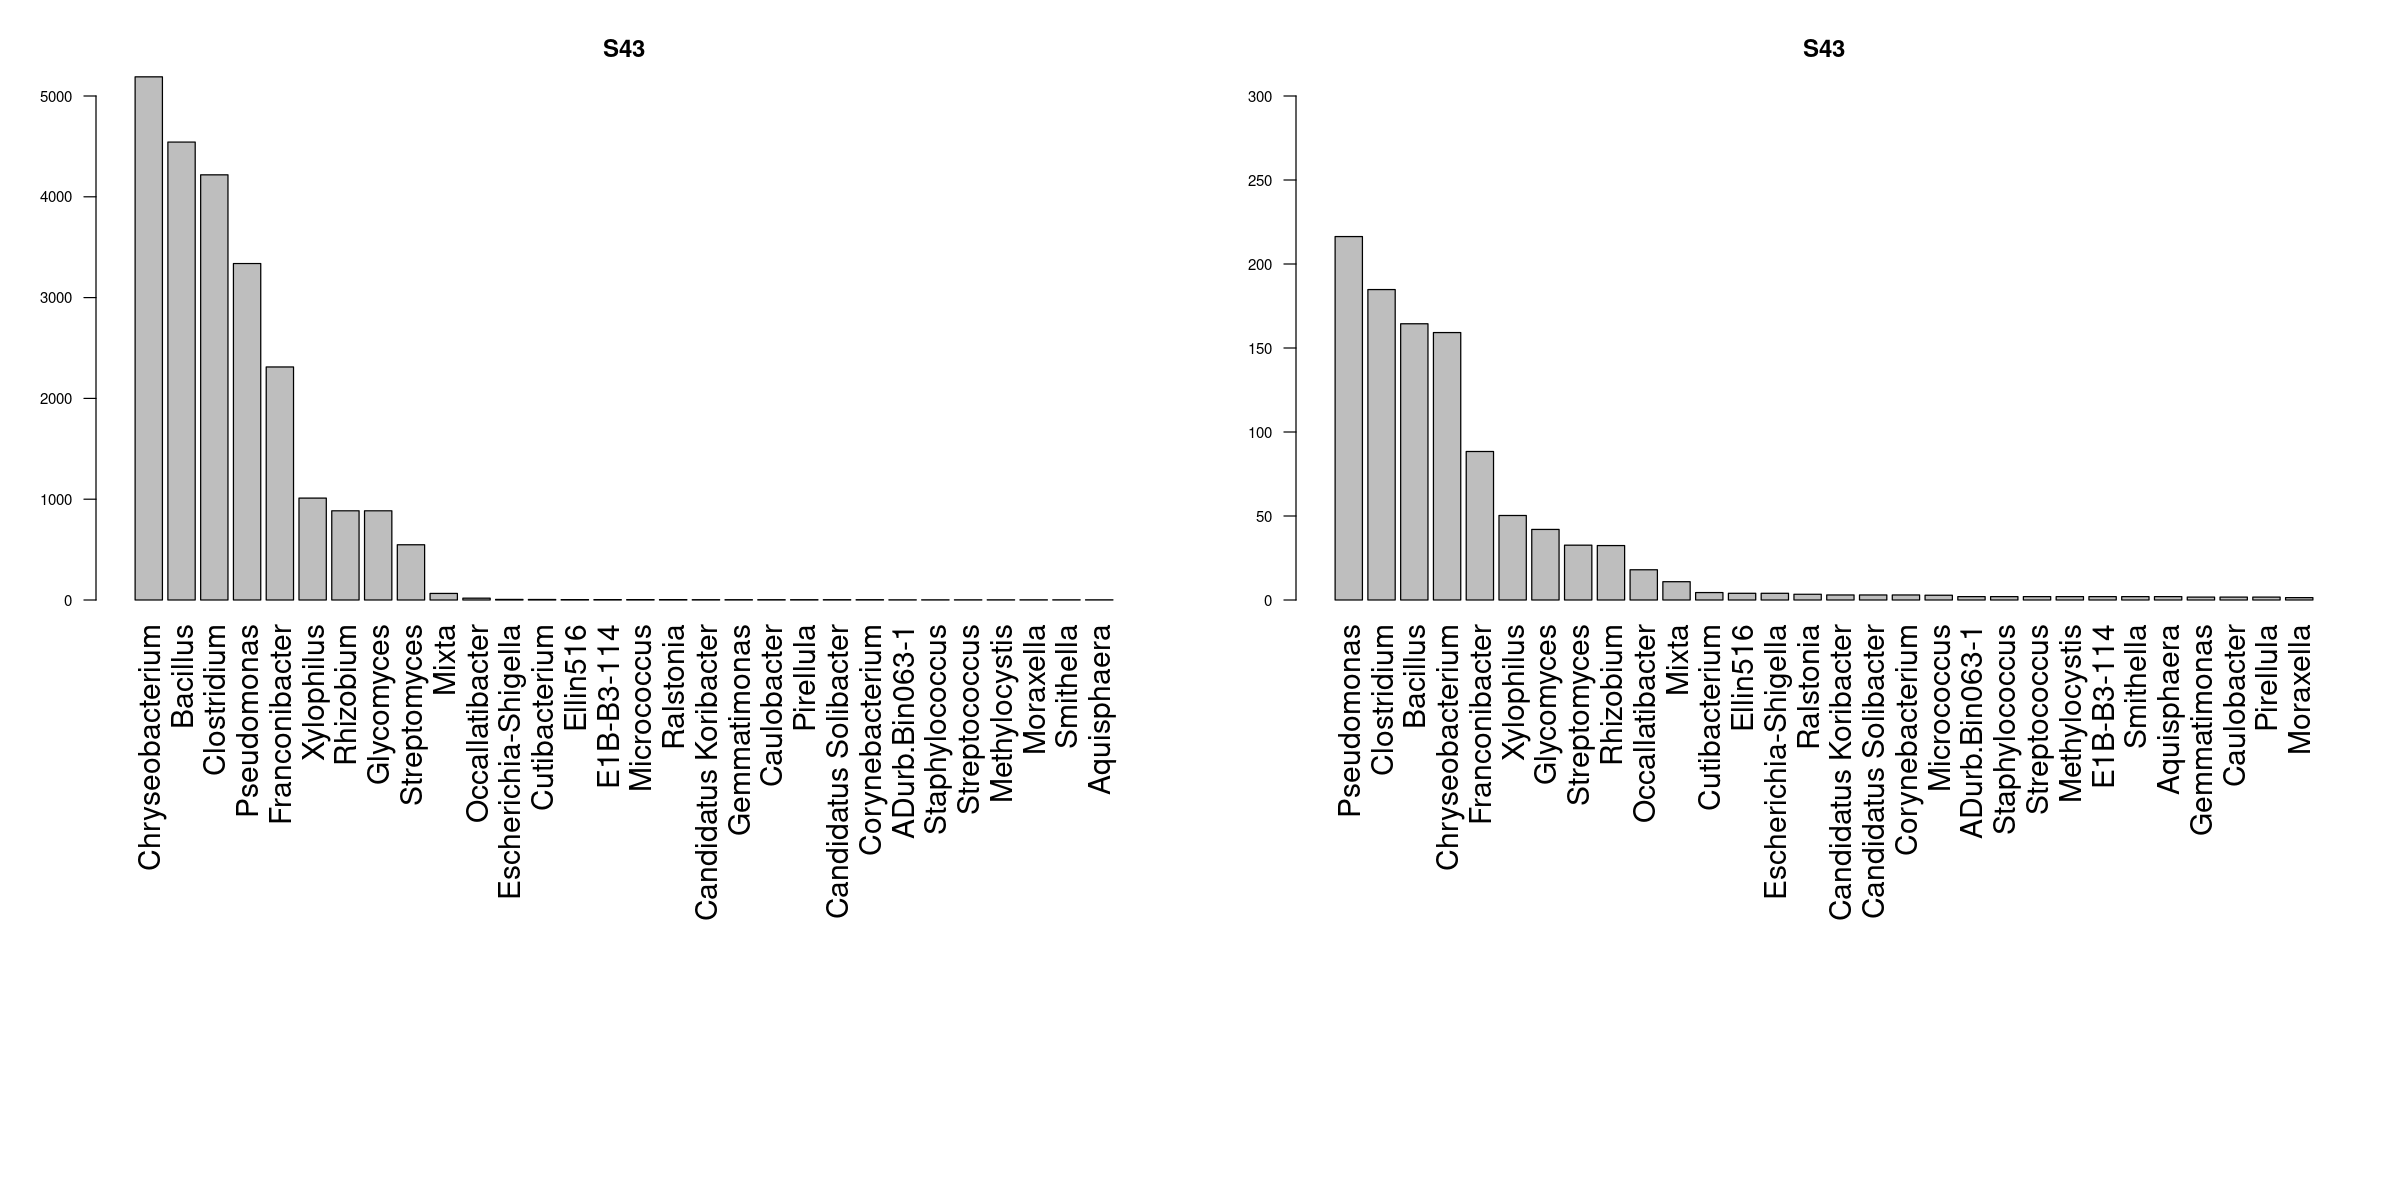

In [134]:
par(mfrow = c(1,2))
rankAb(ps.007.genus, "S43", ylimit=5000, ntax=30)
rankAb(ps007_sqrt_genus, "S43", ylimit=300, ntax=30)

The square root transformation doesn't get rid of the differences in abundances among intended members of our mock community. But we also have to balance the emphasis that these transformations place on the rare OTUs, which in this case are known contaminants. The more we transform down our higher abundances, the more important the rare OTUs become.  The square root transformation can be seen as a compromise between more extreme transformations to bring down hyper-abundances (e.g. - log transforms or presence/absence), vs. elevating contaminants to ecological importance. So another balancing act.

So apply this transformation to our cleaned ps object without any controls that we created above. And to make the samples comparable, convert to relative-abundance.

In [136]:
ps007_cleaned_sqrt <- transform_sample_counts(ps007_cleaned, sqrt)
ps007_cleaned_sqrt_prop <- transform_sample_counts(ps007_cleaned_sqrt, function(otu) otu/sum(otu))

<a id=diversityOverview></a>
## Diversity overview

Domain-level comparison among our samples:

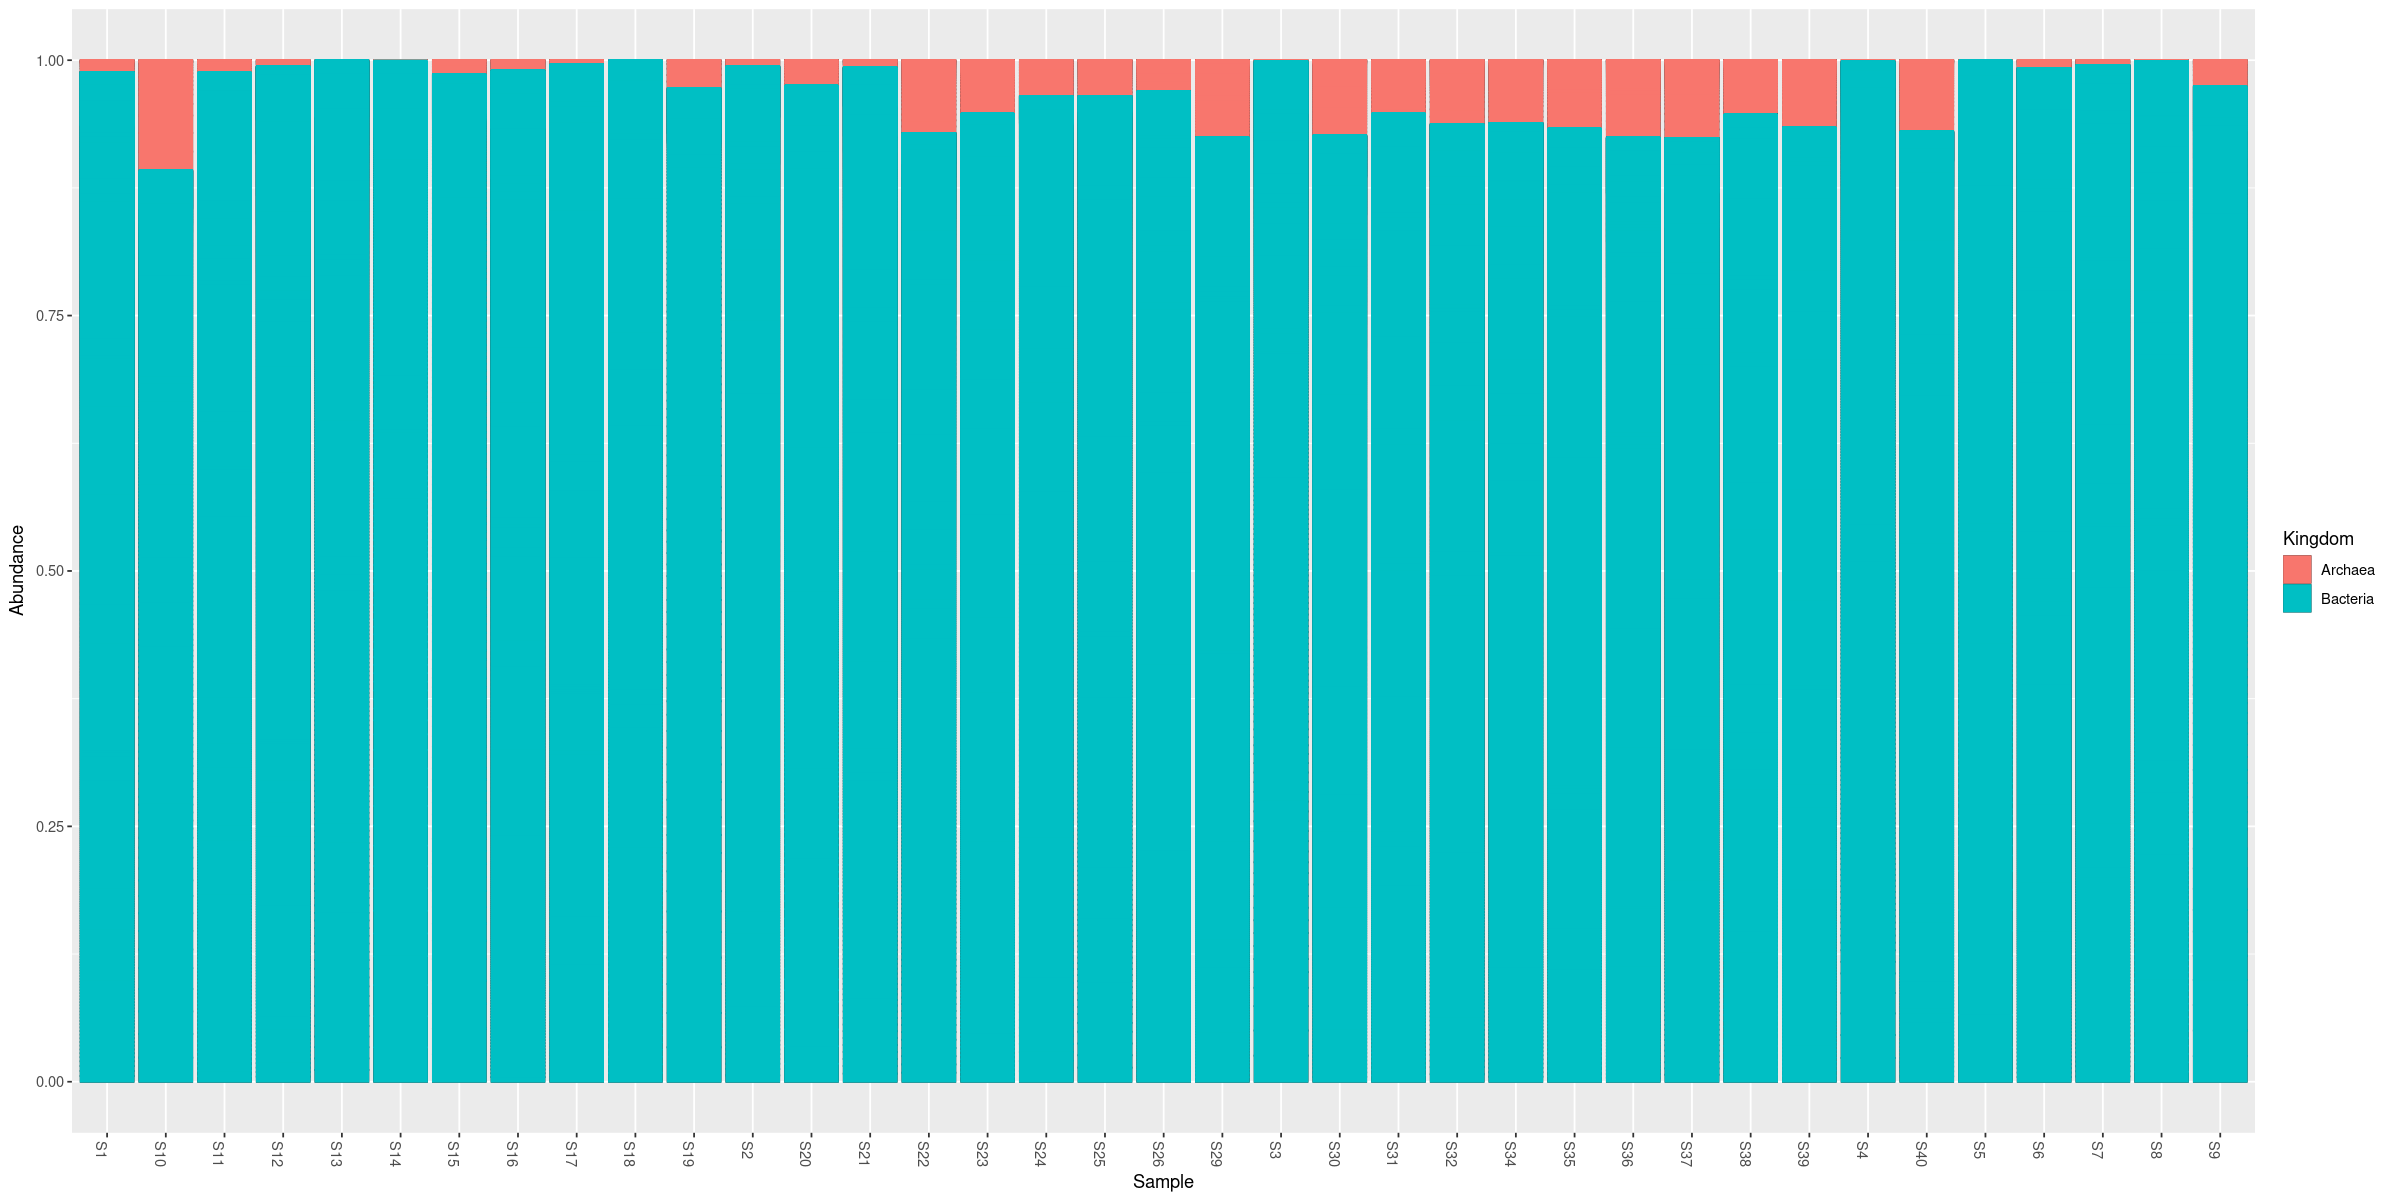

In [137]:
plot_bar(ps007_cleaned_sqrt_prop, fill = "Kingdom") +
  geom_bar(aes(color=Kingdom, fill=Kingdom), stat="identity", position="stack")

If we look at some of these samples that have more Archaea, they look like they are thermokarst:

In [138]:
sample_data(ps)[c("S35","S36","S37","S40")] 

,SampleID,Subsite,DepthSection,EcoCont,Core
,<chr>,<chr>,<dbl>,<chr>,<chr>
S35,AT3_160-180,Thermokarst,5,Ecological,AT3
S36,AT5_0-40,Thermokarst,0,Ecological,AT5
S37,AT5_50-70,Thermokarst,1,Ecological,AT5
S40,AT5_150-170,Thermokarst,5,Ecological,AT5


And the ones without Archaea tend to be palsa:

In [40]:
sample_data(ps)[c("S4","S13","S14","S18")]

,SampleID,Subsite,DepthSection,EcoCont,Core
,<chr>,<chr>,<dbl>,<chr>,<chr>
S4,AP1_80-100,Palsa,4,Ecological,AP1
S13,AP3_50-69,Palsa,3,Ecological,AP3
S14,AP3_80-100,Palsa,4,Ecological,AP3
S18,AP4_50-70,Palsa,3,Ecological,AP4


Let's ordinate and label by depth and subsite (palsa or thermokarst):

In [41]:
s.prop.noC.ord <- ordinate(ps.prop.noC, "NMDS", "bray")

Run 0 stress 0.1280735 
Run 1 stress 0.1280735 
... New best solution
... Procrustes: rmse 1.471527e-06  max resid 3.765906e-06 
... Similar to previous best
Run 2 stress 0.1280735 
... Procrustes: rmse 3.390761e-06  max resid 1.491008e-05 
... Similar to previous best
Run 3 stress 0.1280735 
... Procrustes: rmse 5.737383e-06  max resid 2.54919e-05 
... Similar to previous best
Run 4 stress 0.1280735 
... Procrustes: rmse 4.746932e-06  max resid 2.125891e-05 
... Similar to previous best
Run 5 stress 0.2646365 
Run 6 stress 0.1280735 
... Procrustes: rmse 2.171331e-06  max resid 9.339243e-06 
... Similar to previous best
Run 7 stress 0.2794888 
Run 8 stress 0.1868194 
Run 9 stress 0.1280735 
... Procrustes: rmse 5.957758e-06  max resid 2.619621e-05 
... Similar to previous best
Run 10 stress 0.2061238 
Run 11 stress 0.1280735 
... Procrustes: rmse 1.899054e-06  max resid 8.056075e-06 
... Similar to previous best
Run 12 stress 0.1280735 
... Procrustes: rmse 4.355056e-06  max resid 1.9

In [42]:
bb <- plot_ordination(ps.prop.noC, ps.prop.noC.ord, 
   color="DepthSection",
   shape="Subsite",
)

lbs <- geom_text(label=sample_data(ps.prop.noC)$Core,
                 color = "black",
                 nudge_x = 0.05, nudge_y = 0.05,
                 check_overlap = T)

myPalette <- colorRampPalette(rev(brewer.pal(8, "YlOrBr")))
sc <- scale_colour_gradientn(colours = myPalette(100), limits=c(5, 0), trans="reverse")
bb + sc + lbs + geom_point(size=3.5)

Warning message in scores(ordination, choices = axes, display = "species", physeq = physeq):
“restarting interrupted promise evaluation”
Warning message in plot_ordination(ps.prop.noC, ps.prop.noC.ord, color = "DepthSection", :
“Could not obtain coordinates from the provided `ordination`. 
Please check your ordination method, and whether it is supported by `scores` or listed by phyloseq-package.”


NULL

For some reason that won't work inside the jupyter notebook. Works on my terminal, this is the output:

<img src="ordinationPeat.png" width="950" height="450">